In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


The goal of this notebook is to analyze the difference between air temperature via satellital images and in-situ measuring devices

In [2]:
!pip install requests

In [3]:
import sys
sys.path.append('/content/gdrive/MyDrive/TFG/notebooks/')

In [4]:
from functions import *

Dependencies installed successfully.


In [5]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os
import rasterio
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pyproj
from geopandas.tools import sjoin
from shapely.geometry import Point
import requests
from scipy.stats import ks_2samp

### Functions

In [ ]:
def load_raster(filepath,rgb = True):
  with rasterio.open(filepath) as src:
    if rgb:
      red = src.read(1)
      green = src.read(2)
      blue = src.read(3)
      rgb = np.dstack((red, green, blue))
      return rgb, src
    else:
      return src.read(1), src

In [ ]:
def resize_image(image, new_width, new_height):
    return resize(image, (new_height, new_width), preserve_range=True)

In [ ]:
def load_data(W = None, show = None):
      # Directory containing your images and corresponding prediction images
    image_dir = '/content/gdrive/MyDrive/TFG/data/raw/lst'
    target_dir = '/content/gdrive/MyDrive/TFG/data/raw/wt'

    # List all image files
    image_files = os.listdir(image_dir)
    target_files = os.listdir(target_dir)

    # Initialize lists to store inputs (images) and targets (predictions)
    data_inputs = []
    data_targets = []

    time_slots = []

    # Process each image and its corresponding target
    for img_file, target_file in zip(image_files, target_files):
        # Read the .tif image
        imagen_path = os.path.join(image_dir, img_file)
        img_data,meta = load_raster(imagen_path)
        if show:
          print(img_file)
          plt.imshow(np.clip(img_data*(6/255),0,1))
          plt.show()
          print(img_data.shape)
          print()

        target_path = os.path.join(target_dir, target_file)
        target_data,meta = load_raster(target_path, False)


        # Optionally resize images if needed (implement resize_image function as required)
        if W:
          img_data = resize_image(img_data, W, W)
          target_data = resize_image(target_data, W, W)


        # Append the data to the lists
        data_inputs.append(img_data)
        data_targets.append(target_data)
        time_slots.append(img_file.split('_')[1].split('.')[0])

    # Stack all input and target arrays into final datasets
    data_inputs = np.array(data_inputs)  # Shape: (num_samples, height, width, channels)
    data_targets = np.array(data_targets)  # Shape: (num_samples, height, width, channels)

    # Print shapes for verification
    print('inputs shape:', data_inputs.shape)
    print('targets shape:', data_targets.shape)
    return data_inputs, data_targets, time_slots


In [ ]:
# To obtain regional data the region has to be at least in a 2 degree range

def get_api_data(lon,lat,start_date,end_date):
    # Define API URL and parameters
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "T2M",
        "community": "RE",
        "longitude": lon,  # Replace with your longitude
        "latitude": lat,    # Replace with your latitude
        "start": start_date,            # Replace with start year
        "end": end_date,              # Replace with end year
        "format": "JSON"
    }

    # Make the API request
    response = requests.get(url, params=params)
    data = response.json()
    temperature_data = data['properties']['parameter']['T2M']

    # Convert JSON to DataFrame
    df = pd.DataFrame(list(temperature_data.items()), columns=['Date', 'Temperature'])
    return df


## Load data

In [ ]:
air_temp = pd.read_csv('/content/gdrive/MyDrive/TFG/data/external/30MinFreq_air_interpolated_2008_2024.csv',index_col=0)

In [ ]:
air_temp

RTV028     BOI020     BOI015     BOI019     BOI018  \
2011-01-01 00:00:00   1.391727   1.294197   1.615486   1.527569   1.461206   
2011-01-01 00:30:00   1.313936   1.219181   1.530961   1.445172   1.381550   
2011-01-01 01:00:00   1.339751   1.247110   1.551758   1.467524   1.405988   
2011-01-01 01:30:00   1.290664   1.197264   1.505143   1.419914   1.357729   
2011-01-01 02:00:00   1.282838   1.195127   1.482386   1.402347   1.345307   
...                        ...        ...        ...        ...        ...   
2023-07-31 21:30:00  21.849391  21.805196  21.943537  21.899112  21.877948   
2023-07-31 22:00:00  21.681450  21.622333  21.814899  21.756861  21.721978   
2023-07-31 22:30:00  21.378761  21.318453  21.517233  21.456878  21.421106   
2023-07-31 23:00:00  21.430458  21.379045  21.546593  21.494050  21.465481   
2023-07-31 23:30:00  21.603753  21.554688  21.711471  21.662287  21.636342   

                        BOI021     BOI013     BOI012     BOI011     RTV008  \
2011-01-01 00:00:00   1.335791   1.216945   1.057831   0.870545   0.689521   
2011-01-01 00:30:00   1.260123   1.145596   0.990962   0.805131   0.625199   
2011-01-01 01:00:00   1.287565   1.176447   1.025247   0.840363   0.661116   
2011-01-01 01:30:00   1.237990   1.126766   0.974370   0.787199   0.605765   
2011-01-01 02:00:00   1.234253   1.128950   0.986002   0.807883   0.635003   
...                        ...        ...        ...        ...        ...   
2023-07-31 21:30:00  21.831743  21.771156  21.708564  21.621645  21.543109   
2023-07-31 22:00:00  21.653026  21.576356  21.489035  21.379505  21.279376   
2023-07-31 22:30:00  21.349715  21.274500  21.185183  21.068951  20.962065   
2023-07-31 23:00:00  21.407624  21.340376  21.267640  21.172163  21.086728   
2023-07-31 23:30:00  21.582571  21.516942  21.447074  21.353738  21.269286   

                        BOI009     RTV045     BOI006     BOI005     BOI001  \
2011-01-01 00:00:00   0.478119  -0.186143  -0.544054  -0.628377  -0.603609   
2011-01-01 00:30:00   0.414527  -0.250205  -0.608693  -0.693177  -0.669160   
2011-01-01 01:00:00   0.450856  -0.214548  -0.573570  -0.658166  -0.634761   
2011-01-01 01:30:00   0.393297  -0.276531  -0.636637  -0.720618  -0.696259   
2011-01-01 02:00:00   0.430974  -0.223919  -0.581023  -0.667810  -0.649197   
...                        ...        ...        ...        ...        ...   
2023-07-31 21:30:00  21.442746  21.006457  20.693724  20.544537  20.414105   
2023-07-31 22:00:00  21.157383  20.681683  20.361092  20.220356  20.107445   
2023-07-31 22:30:00  20.832704  20.339960  20.015191  19.878249  19.773329   
2023-07-31 23:00:00  20.980916  20.538424  20.224490  20.074467  19.940113   
2023-07-31 23:30:00  21.163244  20.716986  20.402258  20.255003  20.128476   

                        RTV021     BOI017     BOI008     BOI016  
2011-01-01 00:00:00  -0.627923  -0.180028   0.116948  -0.627412  
2011-01-01 00:30:00  -0.693043  -0.244050   0.053790  -0.692097  
2011-01-01 01:00:00  -0.658288  -0.208329   0.090298  -0.657030  
2011-01-01 01:30:00  -0.720277  -0.269739   0.030222  -0.720500  
2011-01-01 02:00:00  -0.670092  -0.219201   0.077398  -0.663367  
...                        ...        ...        ...        ...  
2023-07-31 21:30:00  20.477071  20.975757  21.224433  20.642893  
2023-07-31 22:00:00  20.160913  20.656734  20.913932  20.305772  
2023-07-31 22:30:00  19.822365  20.317548  20.579766  19.957692  
2023-07-31 23:00:00  20.005505  20.508073  20.758495  20.173856  
2023-07-31 23:30:00  20.189327  20.687669  20.938655  20.350368  

[220560 rows x 19 columns]

In [ ]:
W = 64 # with 64 works LR
data_inputs, data_targets, time_slots = load_data()

inputs shape: (22, 359, 312, 3)
targets shape: (22, 372, 300)


Filter air temperature data of the stations for the period of available LST data of Landsat

In [ ]:
sorted_dates = sorted(pd.to_datetime(time_slots))

In [ ]:
air_temp.index = pd.to_datetime(air_temp.index)

In [ ]:
period = [d.strftime("%Y-%m") for d in sorted_dates]

In [ ]:
air_temp_filt = air_temp.loc[period[0]:period[-1]]

Read and project stations geography

In [ ]:
stations_coord = pd.read_csv('/content/gdrive/MyDrive/TFG/data/external/water_stations_with_Qratio.csv')
stations_coord

CODE_MdlR     CODE_RTV_2021  Coord X  Coord Y  \
0     RTV028  RTV_BOM_LEM_0388  2525323  1150240   
1     BOI020  RTV_BLA_BOM_0397  2524895  1150320   
2     BOI015  RTV_BOM_LEM_0372  2526344  1149431   
3     BOI019  RTV_BOM_LEM_0379  2526007  1149860   
4     BOI018  RTV_BOM_LEM_0383  2525635  1149957   
5     BOI021  RTV_BOM_LEM_0392  2525010  1150251   
6     BOI013  RTV_BOM_LEM_0406  2524447  1149734   
7     BOI012  RTV_BOM_LEM_0421  2523618  1149689   
8     BOI011  RTV_BOM_LEM_0440  2522970  1150411   
9     RTV008  RTV_BOM_LEM_0459  2522299  1151035   
10    BOI009  RTV_BOM_LEM_0484  2521553  1151594   
11    RTV045  RTV_BOM_LEM_0581  2519932  1153004   
12    BOI006  RTV_BOM_LEM_0641  2519417  1153930   
13    BOI005  RTV_BOM_LEM_0660  2519755  1154390   
14    BOI001  RTV_BOM_LEM_0662  2520022  1155807   
15    RTV021  RTV_BOM_LEM_0663  2519927  1155040   
16    BOI017  RTV_BTM_BOM_0583  2520218  1152931   
17    BOI008  RTV_BTM_BOM_0535  2520528  1152013   
18    BOI016  RTV_BTM_BOM_0654  2519171  1153856   

    Taux de recouvrement de la ripisylve (%)  Altitude  WGS84_Latitude  \
0                                        100       388       46.499294   
1                                        100       397       46.499966   
2                                        100       372       46.492131   
3                                         75       379       46.495952   
4                                         80       383       46.496784   
5                                        100       392       46.499358   
6                                        100       406       46.494644   
7                                        100       421       46.494145   
8                                         90       440       46.500565   
9                                         70       459       46.506101   
10                                        65       484       46.511042   
11                                        85       581       46.523532   
12                                        90       641       46.531799   
13                                       100       660       46.535978   
14                                        25       662       46.548755   
15                                        55       663       46.541845   
16                                        90       583       46.522910   
17                                         0       535       46.514689   
18                                         0       654       46.531104   

    WGS84_Longitude     ratio  
0          6.465835  0.808703  
1          6.460247  0.319376  
2          6.479263  1.000000  
3          6.474805  1.000000  
4          6.469945  0.808703  
5          6.461756  0.489327  
6          6.454508  0.489327  
7          6.443718  0.489327  
8          6.435158  0.540832  
9          6.426312  0.392029  
10         6.416499  0.623116  
11         6.395136  0.412473  
12         6.388263  0.191589  
13         6.392588  0.194444  
14         6.395822  0.247934  
15         6.394717  0.188525  
16         6.398875  0.046729  
17         6.403073  0.623116  
18         6.385070  0.000000

In [ ]:
import folium

# Create a map centered around the average latitude and longitude of the stations
center_lat = stations_coord['WGS84_Latitude'].mean()
center_lon = stations_coord['WGS84_Longitude'].mean()

# Initialize a folium map
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Add the stations as points on the map
for i, row in stations_coord.iterrows():
    folium.Marker(
        location=[row['WGS84_Latitude'], row['WGS84_Longitude']],
        popup=f"Station: {row['CODE_MdlR']}, Ratio: {row['ratio']}"
    ).add_to(m)

# Save the map to an HTML file
map_path = "/content/gdrive/MyDrive/TFG/maps/water_stations_map.html"
m.save(map_path)

from google.colab import files
files.download(map_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

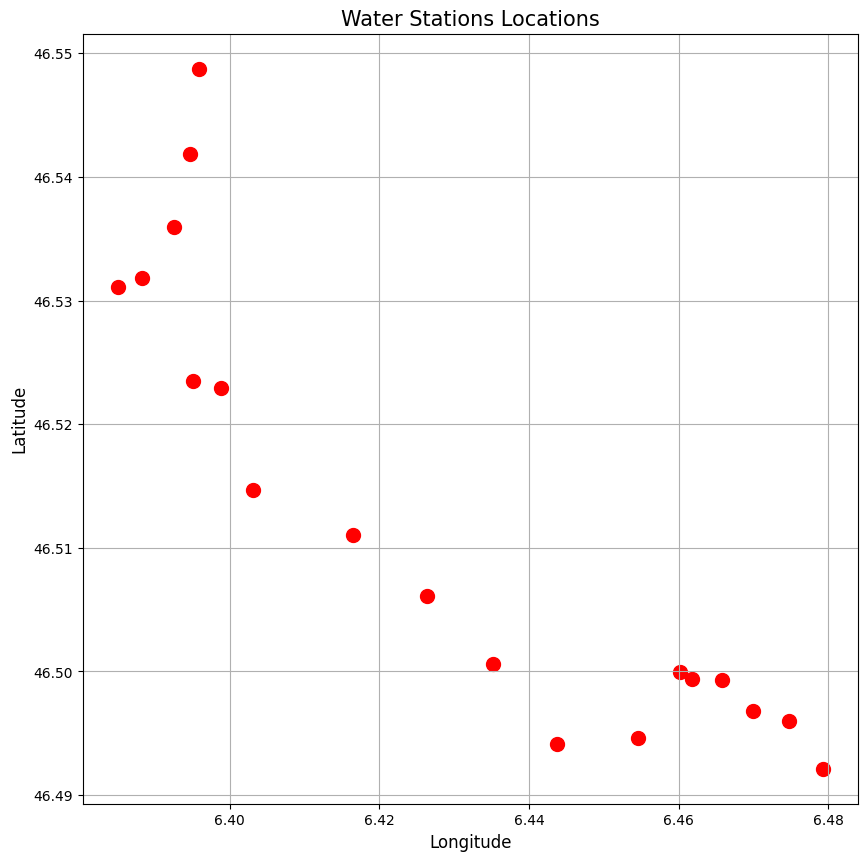

In [ ]:
# Plot the water stations without a basemap, using a simple latitude and longitude grid
fig, ax = plt.subplots(figsize=(10, 10))

# Scatter plot of the stations using latitude and longitude
ax.scatter(stations_coord['WGS84_Longitude'], stations_coord['WGS84_Latitude'], color='red', s=100)

# Adding labels and title
ax.set_title('Water Stations Locations', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Show the plot
plt.grid(True)
plt.show()


## Obtain old data from Landsat

## Obtain air temperature data through NASA POWER

In [ ]:
boiron = gpd.read_file('/content/gdrive/MyDrive/TFG/data/external/swissTLMboiron')
boiron = boiron.to_crs("EPSG:4326")
bounds = boiron.total_bounds
bounds

array([ 6.37508881, 46.48057743,  6.4925946 , 46.58019354])

In [ ]:
lon_min, lat_min, lon_max, lat_max = boiron.total_bounds


In [ ]:
start_date = '20130301'
end_date = '20141231'

stations_df = {}

for i, station in stations_coord.iterrows():
  lon = station.WGS84_Longitude
  lat = station.WGS84_Latitude
  df = get_api_data(lon,lat,start_date,end_date)
  df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

  #df.set_index('Date', inplace=True)
  stations_df[station.CODE_MdlR] = list(df['Temperature'])
  stations_df['Date'] = list(df['Date'])



In [ ]:
stations_df = pd.DataFrame(stations_df)

In [ ]:
daily_mean = air_temp_filt.resample('D').mean()
daily_mean = daily_mean.reset_index()
daily_mean = daily_mean.rename(columns={'index':'Date'})

## Statistical comparison

### NASA POWER and measuring stations (interpolated with water stations)

In [ ]:
p_values = {}
for column in stations_df.columns:
  if column != 'Date':
    # Plot histograms to compare the distributions
    print('Results for station', column)
    plt.figure(figsize=(10,6))
    plt.hist(stations_df[column], alpha=0.5, label='Temperature NASA POWER', bins=10)
    plt.hist(daily_mean[column], alpha=0.5, label='Temperature interpolation', bins=10)
    plt.legend(loc='upper right')
    plt.title('Temperature Distributions')
    plt.xlabel('Temperature')
    plt.ylabel('Frequency')
    plt.show()

    # Optionally, plot KDE (Kernel Density Estimate)
    stations_df[column].plot(kind='kde', label='Temperature NASA POWER', figsize=(10,6))
    daily_mean[column].plot(kind='kde', label='Temperature interpolation')
    plt.legend()
    plt.title('Temperature KDE Comparison')
    plt.xlabel('Temperature')
    plt.show()

    # Optionally, boxplot for quick comparison of distributions
    data = [stations_df[column], daily_mean[column]]

    # Plot the boxplot for both datasets
    plt.figure(figsize=(8,6))
    plt.boxplot(data, labels=['RTV028_df1', 'RTV028_df2'])

    plt.title('Temperature Distribution Comparison (Boxplot)')
    plt.show()


    plt.figure(figsize=(10,6))
    # Plot df1
    plt.plot(stations_df['Date'], stations_df[column], label='Temperature NASA POWER', marker='o')

    # Plot df2
    plt.plot(daily_mean['Date'], daily_mean[column], label='Temperature interpolation', marker='o')

    # Customize the plot
    plt.title('Temperature Evolution Over Time')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()
    print()
    print()

    stat, p_value = ks_2samp(stations_df[column], daily_mean[column])
    mse = mean_squared_error(stations_df[column], daily_mean[column])
    rmse = np.sqrt(mse)

    p_values[column] = [p_value,rmse]

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
pd.DataFrame(p_values,index=['ks p_value', 'RMSE'])

RTV028    BOI020        BOI015    BOI019    BOI018    BOI021  \
ks p_value  0.000003  0.000008  8.690444e-07  0.000002  0.000003  0.000005   
RMSE        2.581660  2.528042  2.693334e+00  2.646547  2.616041  2.554644   

              BOI013    BOI012    BOI011    RTV008    BOI009    RTV045  \
ks p_value  0.000011  0.000041  0.000087  0.000180  0.000452  0.011137   
RMSE        2.480890  2.395727  2.293499  2.196533  2.080041  1.714575   

              BOI006    BOI005    BOI001    RTV021    BOI017    BOI008  \
ks p_value  0.074330  0.127133  0.127133  0.127133  0.011137  0.002471   
RMSE        1.553777  1.513947  1.506343  1.506702  1.709516  1.873713   

              BOI016  
ks p_value  0.127133  
RMSE        1.527148

### Landsat and air stations (interpolated with le boiron shp)

Load data

In [ ]:
def load_data(dir_paths,W = None, rgb = [], show = None):
    # Directory containing your images and corresponding prediction images
    data = []
    for i,path in enumerate(dir_paths):
      image_files = os.listdir(path)
      imgs_data = []
      for img_file in image_files:
        imagen_path = os.path.join(path, img_file)
        img_data,meta = load_raster(imagen_path,rgb[i])
        if W:
          img_data = resize_image(img_data, W, W)
        imgs_data.append(img_data)
      if len(dir_paths) > 1:
        data.append(np.array(imgs_data))
      else:
        data = np.array(imgs_data)

    return data

In [ ]:
import os
import numpy as np
import re  # To extract dates from filenames

# Function to extract the year and month from the filename
def extract_year_month_from_filename(filename):
    # Adjust regex to match the YYYY-MM format
    match = re.search(r'(\d{4})-(\d{2})', filename)
    if match:
        return match.group(0)  # Return the matched year and month as a string (YYYY-MM)
    return None

def load_data(dir_paths, W=None, rgb=[], show=None):
    data = []
    for i, path in enumerate(dir_paths):
        image_files = os.listdir(path)

        # Filter out files without a valid date in the filename
        valid_image_files = [img for img in image_files if extract_year_month_from_filename(img) is not None]

        # Sort the valid image files by year and month extracted from the filename
        valid_image_files = sorted(valid_image_files, key=lambda x: extract_year_month_from_filename(x))

        imgs_data = []
        for img_file in valid_image_files:
            imagen_path = os.path.join(path, img_file)
            img_data, meta = load_raster(imagen_path, rgb[i])  # Load raster data

            if W:  # Resize the image if W is provided
                img_data = resize_image(img_data, W, W)

            imgs_data.append(img_data)

        if len(dir_paths) > 1:
            data.append(np.array(imgs_data))
        else:
            data = np.array(imgs_data)

    return data

# Example usage:
# dir_paths = ['path/to/dir1', 'path/to/dir2']
# rgb = [True, False]


In [ ]:
W = 256 # with 64 works LR
dir_paths = ['/content/gdrive/MyDrive/TFG/data/raw/lst','/content/gdrive/MyDrive/TFG/data/external/air temperature interpolated']
data = load_data(dir_paths,W,[True,False])
lst_data = data[0]
airtemp_data = data[1]

afegeixo image_2013-03.tiff
afegeixo image_2013-04.tiff
afegeixo image_2013-05.tiff
afegeixo image_2013-06.tiff
afegeixo image_2013-07.tiff
afegeixo image_2013-08.tiff
afegeixo image_2013-09.tiff
afegeixo image_2013-10.tiff
afegeixo image_2013-11.tiff
afegeixo image_2013-12.tiff
afegeixo image_2014-01.tiff
afegeixo image_2014-02.tiff
afegeixo image_2014-03.tiff
afegeixo image_2014-04.tiff
afegeixo image_2014-05.tiff
afegeixo image_2014-06.tiff
afegeixo image_2014-07.tiff
afegeixo image_2014-08.tiff
afegeixo image_2014-09.tiff
afegeixo image_2014-10.tiff
afegeixo image_2014-11.tiff
afegeixo image_2014-12.tiff
afegeixo airtemp_2013-03.tif
afegeixo airtemp_2013-04.tif
afegeixo airtemp_2013-05.tif
afegeixo airtemp_2013-06.tif
afegeixo airtemp_2013-07.tif
afegeixo airtemp_2013-08.tif
afegeixo airtemp_2013-09.tif
afegeixo airtemp_2013-10.tif
afegeixo airtemp_2013-11.tif
afegeixo airtemp_2013-12.tif
afegeixo airtemp_2014-01.tif
afegeixo airtemp_2014-02.tif
afegeixo airtemp_2014-03.tif
afegeix

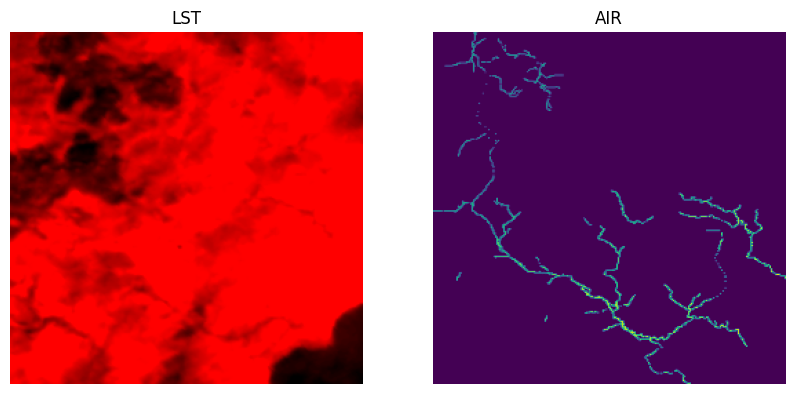

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



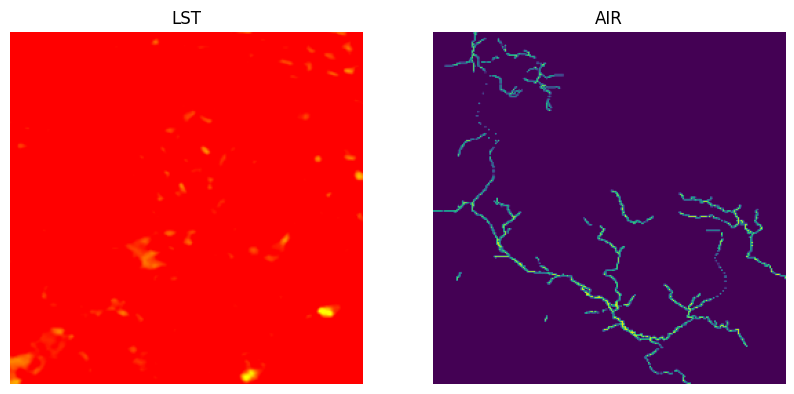

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



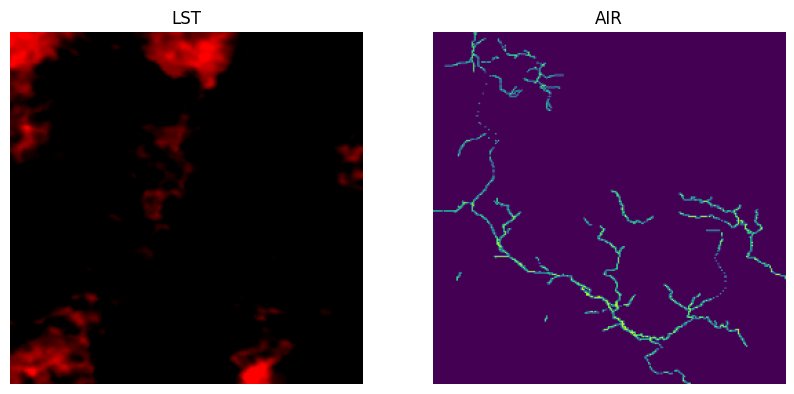

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



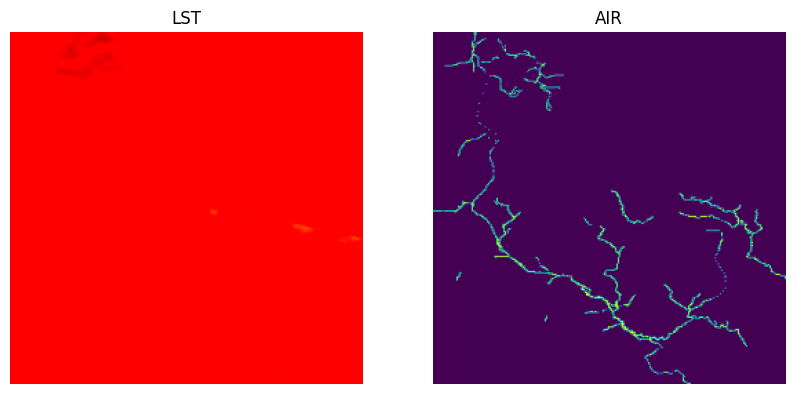

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



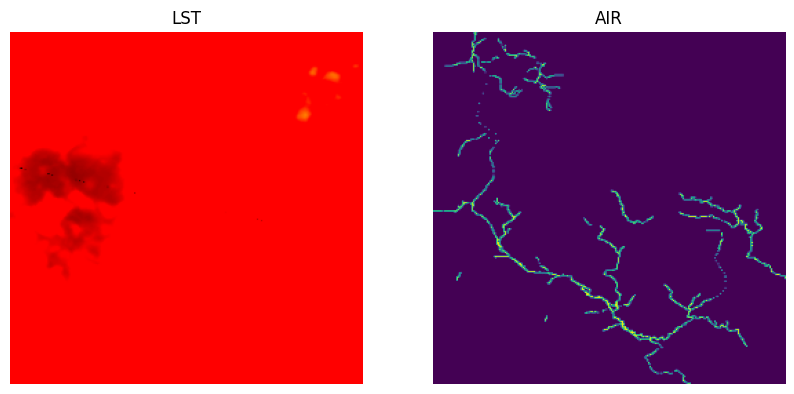

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



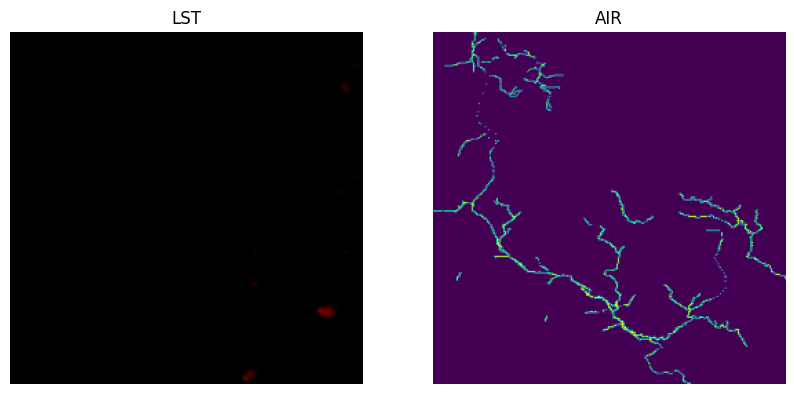

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



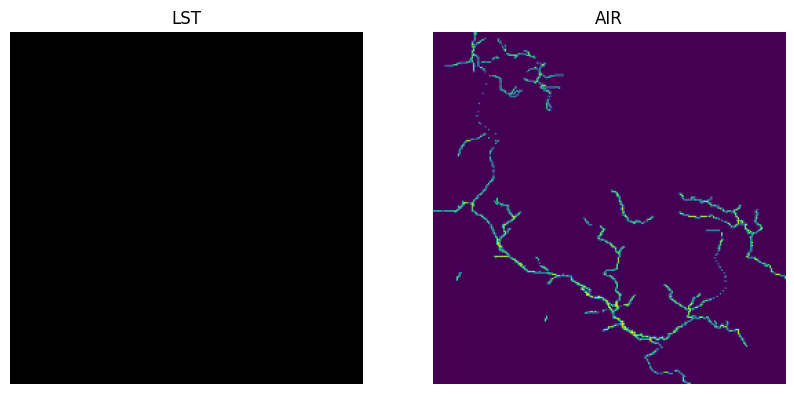

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



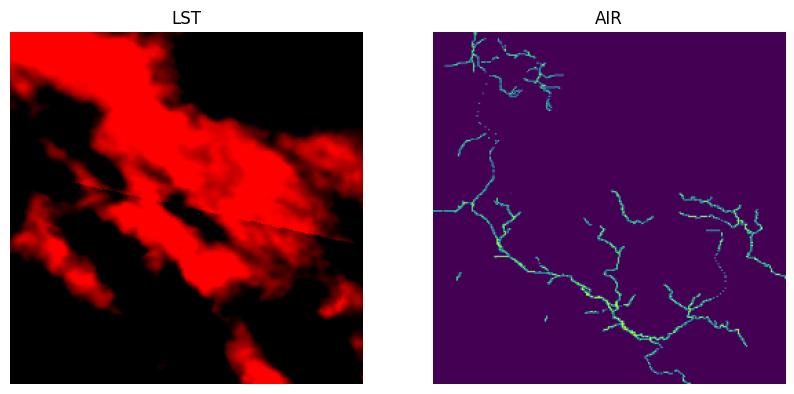

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



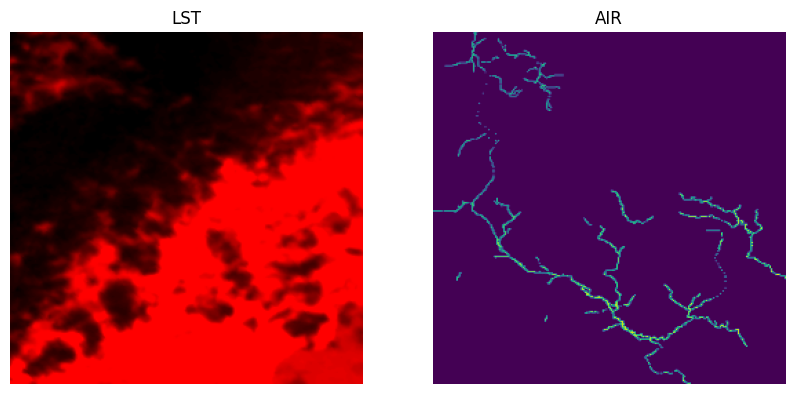

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



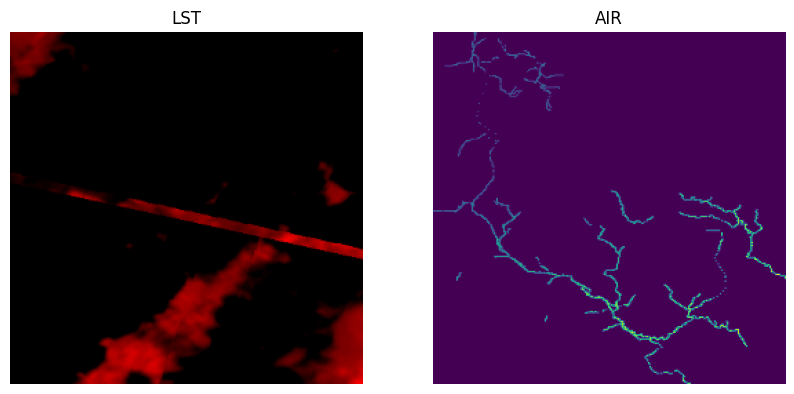

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



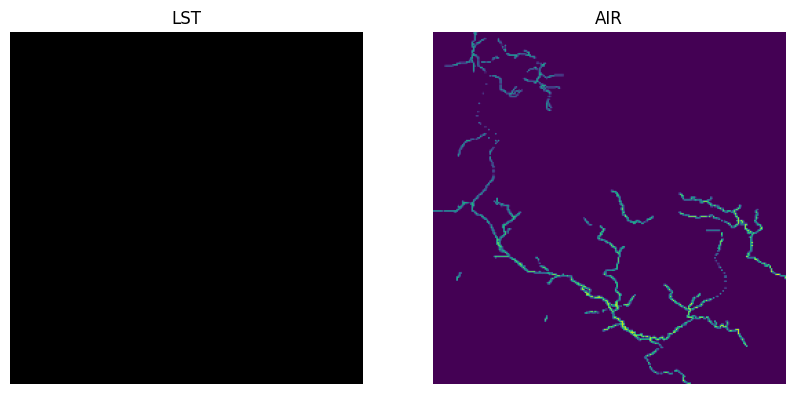

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



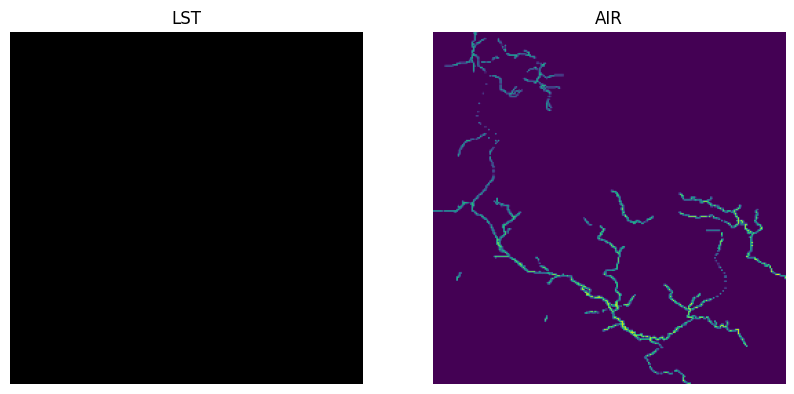

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



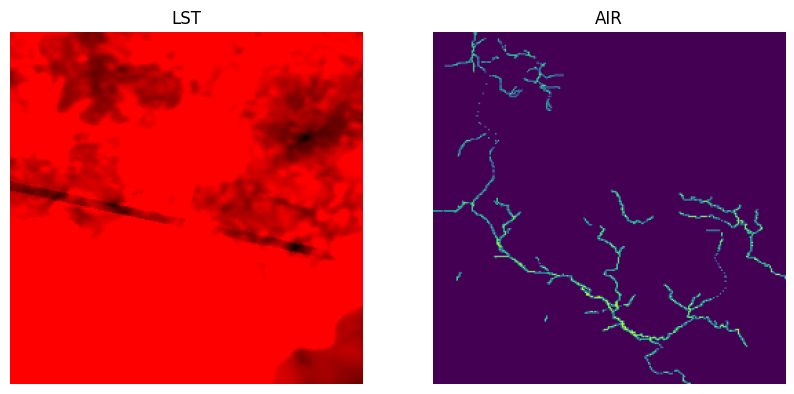

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



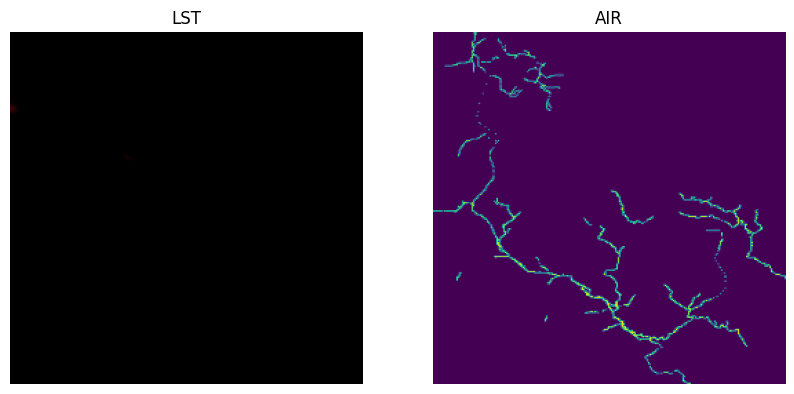

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



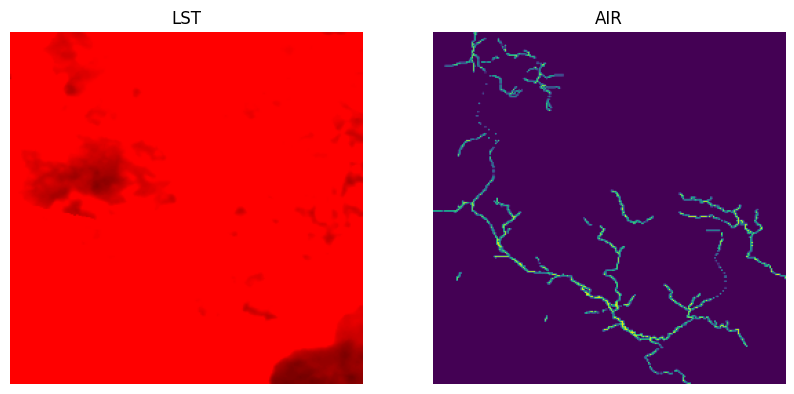

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



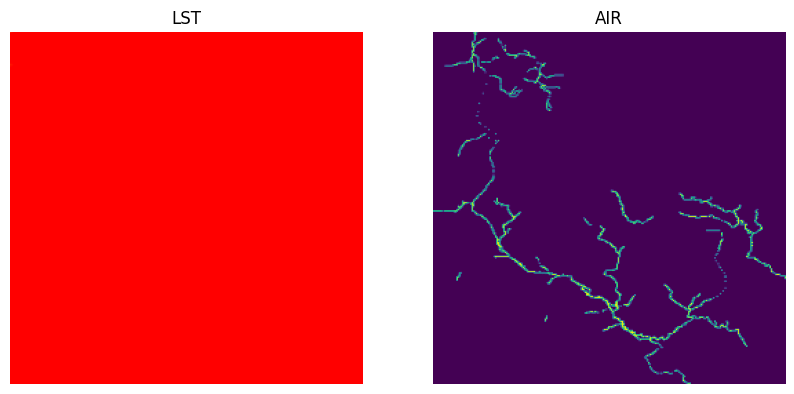

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



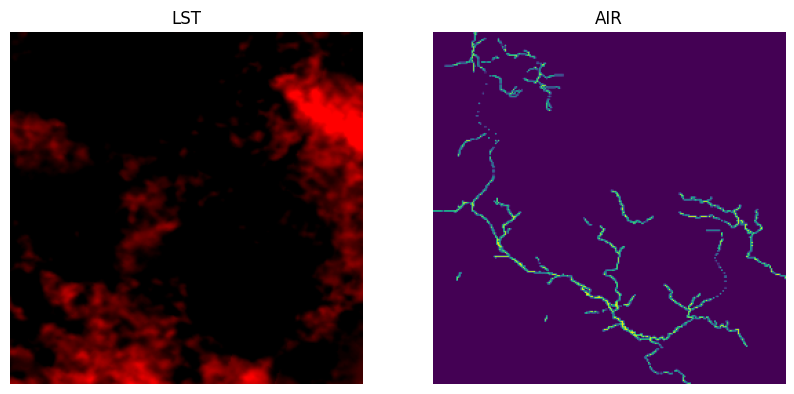

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



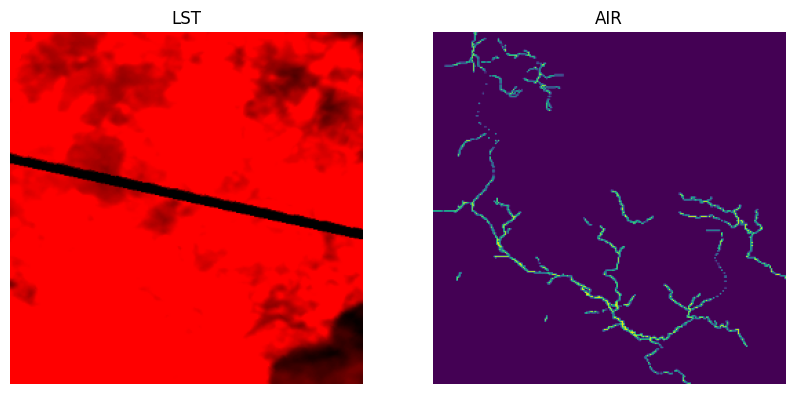

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



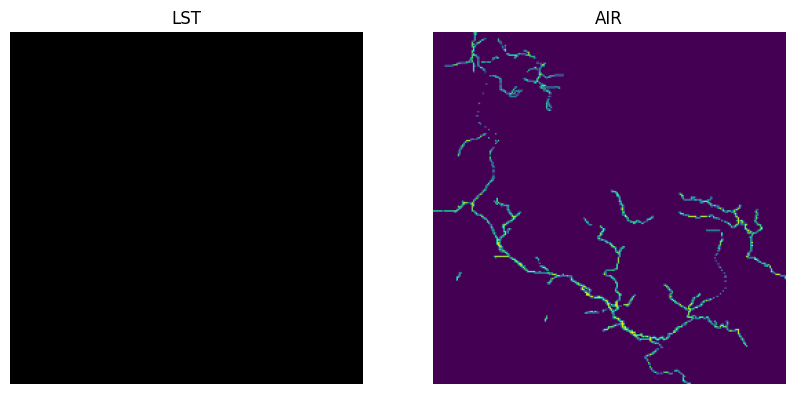

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



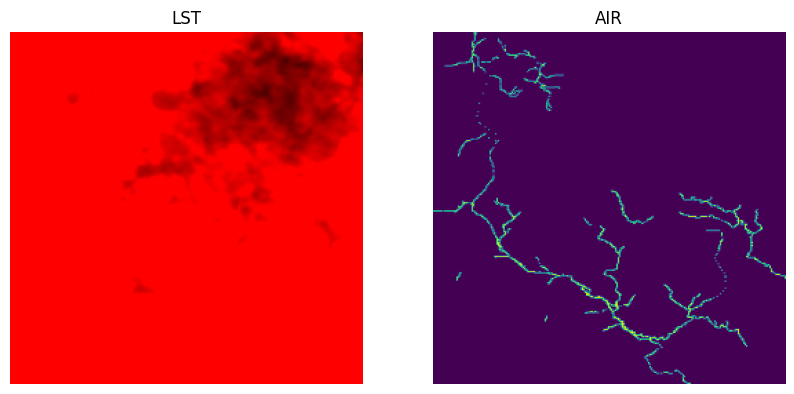

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



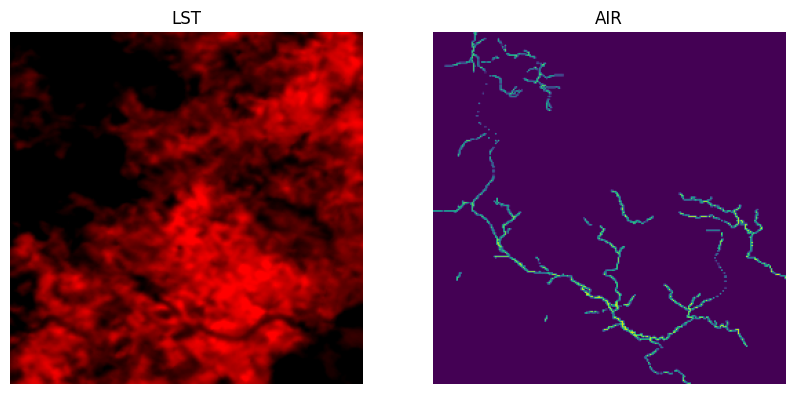

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



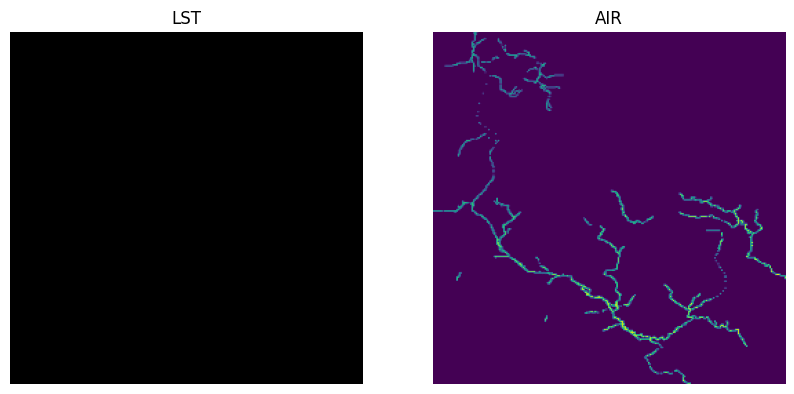

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming lst_data and airtemp_data are lists of arrays
for img_data, airtemp_dat in zip(lst_data, airtemp_data):
    # Create a figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the figure size if needed

    # Plot the first image (LST)
    axes[0].imshow(np.clip(img_data * (6/255), 0, 1))
    axes[0].set_title('LST')
    axes[0].axis('off')  # Remove the axis

    # Plot the second image (AIR)
    axes[1].imshow(airtemp_dat)
    axes[1].set_title('AIR')
    axes[1].axis('off')  # Remove the axis

    # Show the images side by side
    plt.show()

    # Optionally, print the shape of the images
    print('LST Shape:', img_data.shape)
    print('AIR Shape:', airtemp_dat.shape)
    print()


#### Filter to obtain only river data

In [ ]:
river_mask = airtemp_data[0]  # Cambia el índice según sea necesario

# Imprimir la forma de la imagen seleccionada
print('Selected image shape:', river_mask.shape)

Selected image shape: (256, 256)


In [ ]:
river_mask_expanded = np.expand_dims(river_mask, axis=-1)  # Expande para tener forma (height, width, 1)
river_mask_expanded = np.repeat(river_mask_expanded, lst_data.shape[-1], axis=-1)  # Expande a (height, width, 3)

# Aplica la máscara solo a las entradas (inputs)
masked_inputs = []

for input_img in lst_data:
    masked_input = input_img * river_mask_expanded  # Aplica la máscara a los inputs
    masked_inputs.append(masked_input)

# Convierte de nuevo a arrays de numpy
masked_inputs = np.array(masked_inputs)


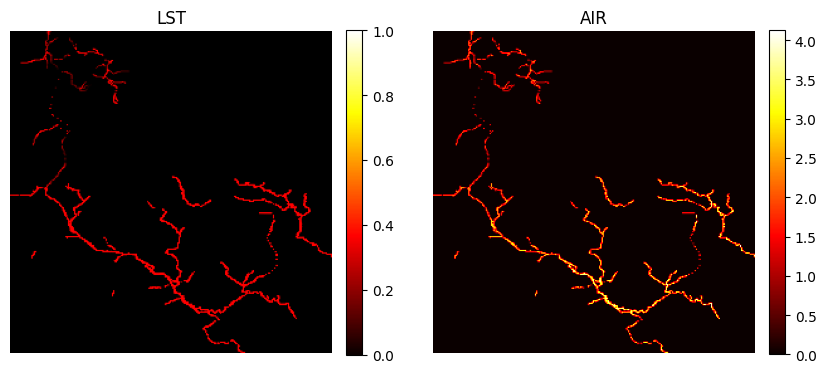

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



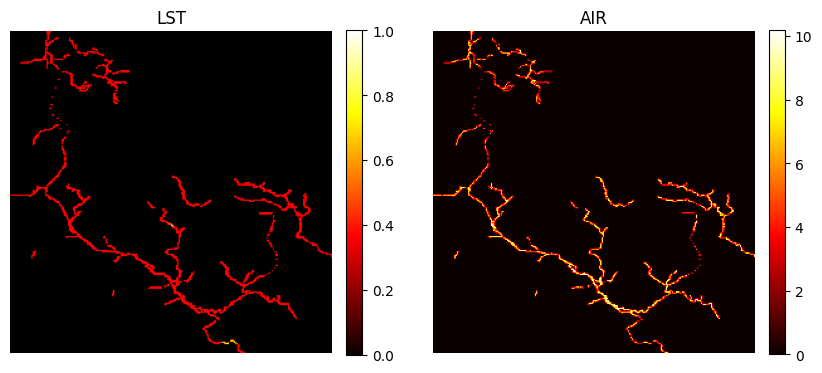

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



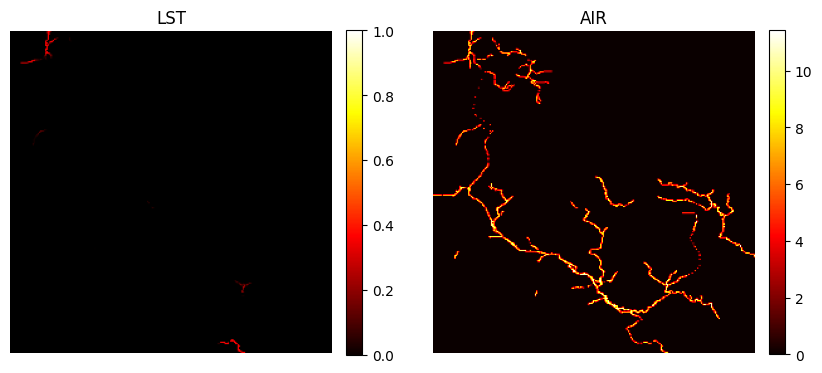

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



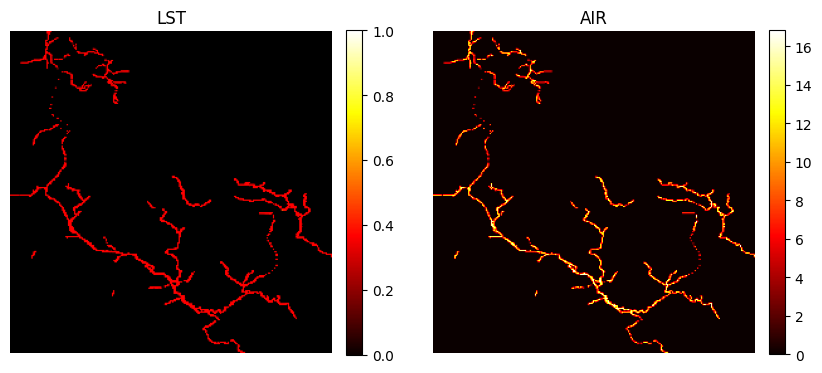

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



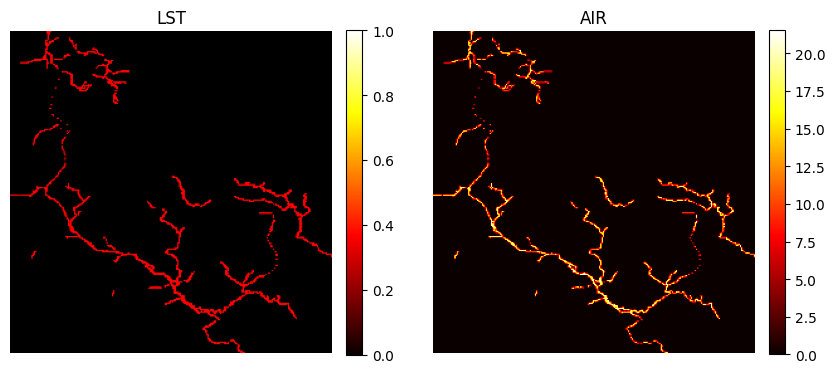

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



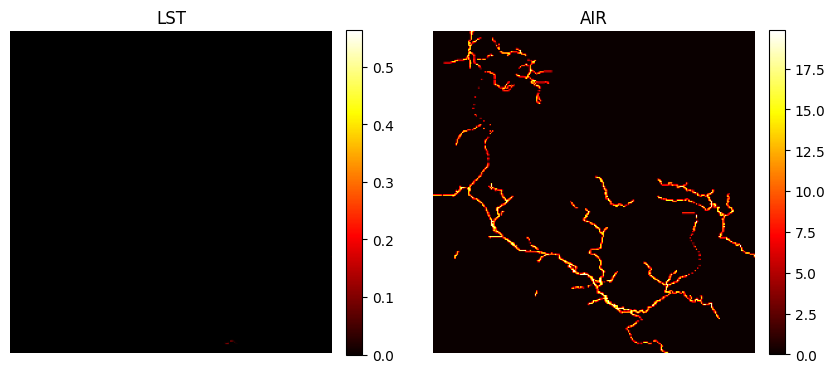

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



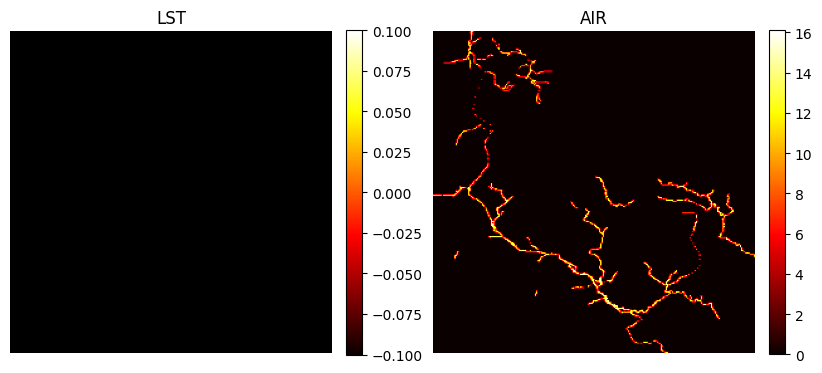

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



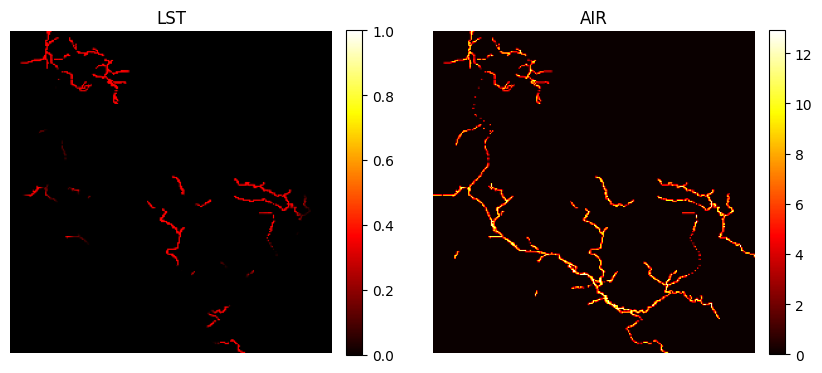

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



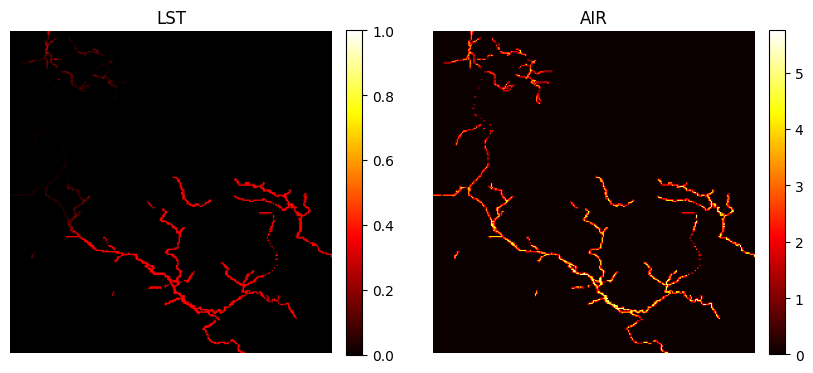

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



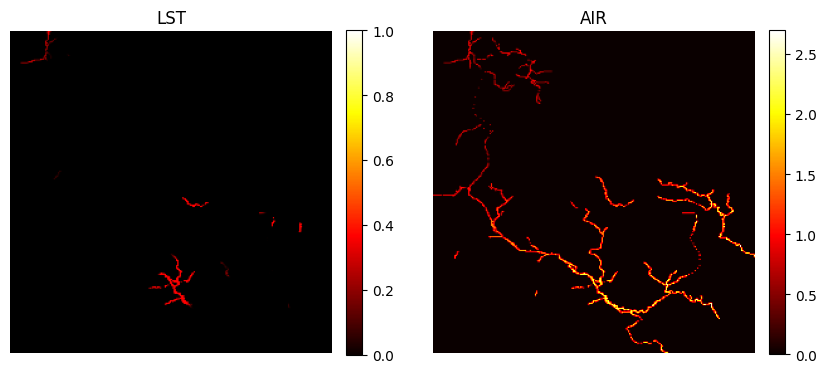

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



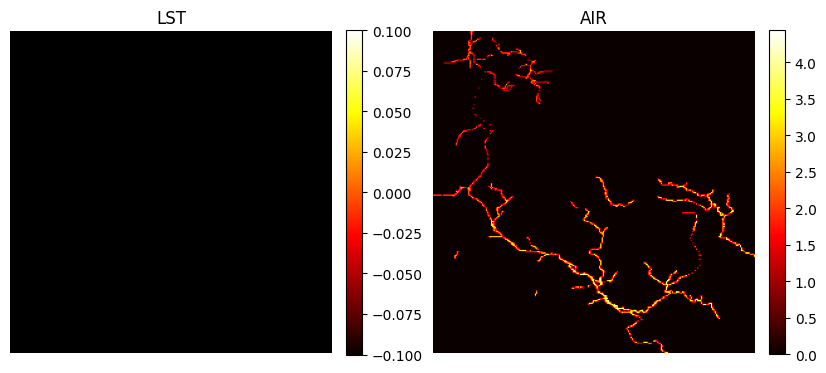

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



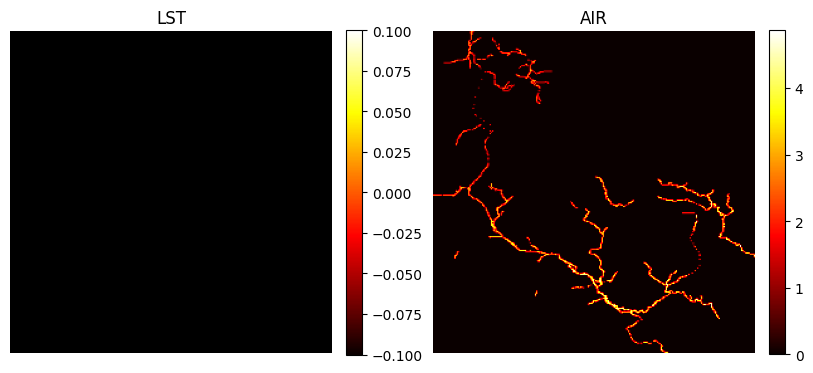

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



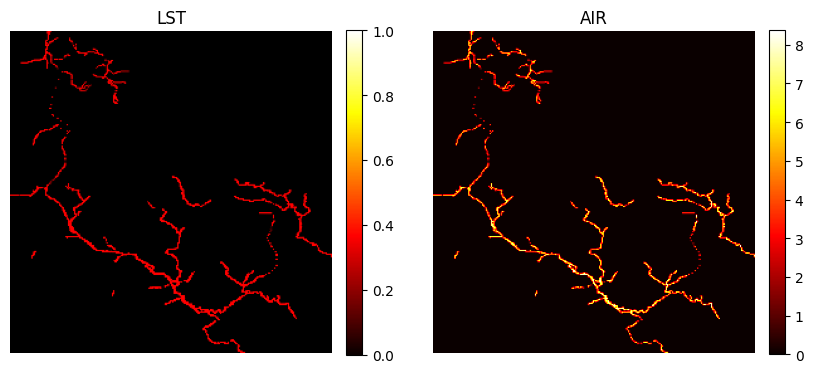

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



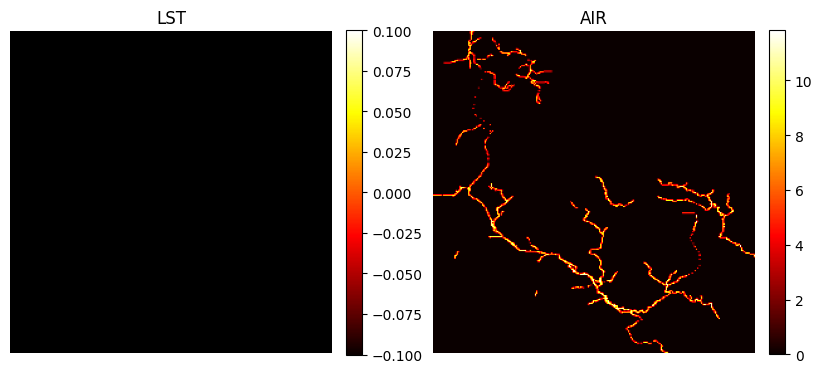

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



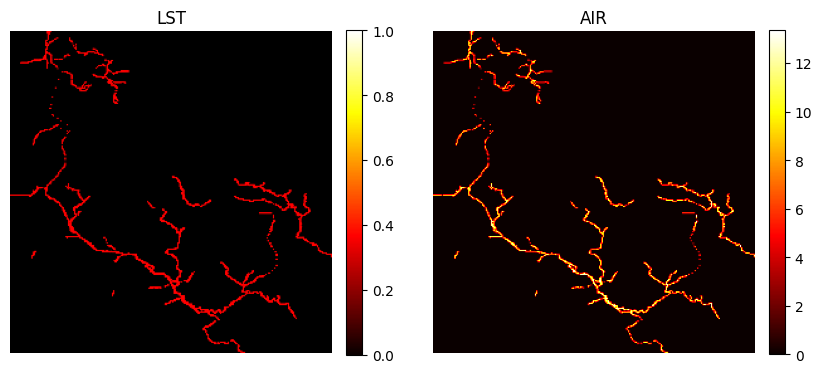

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



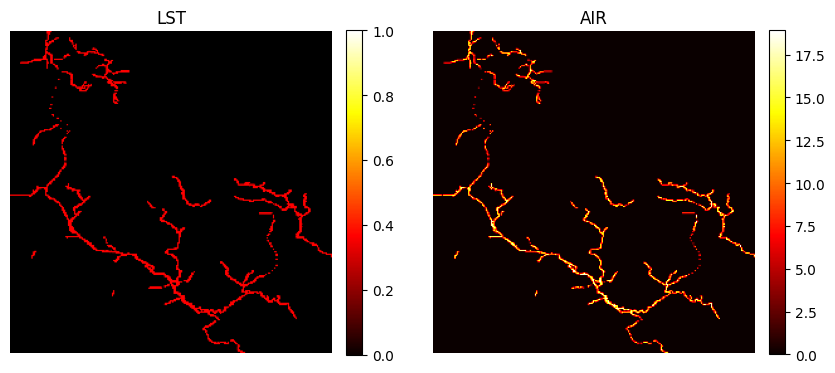

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



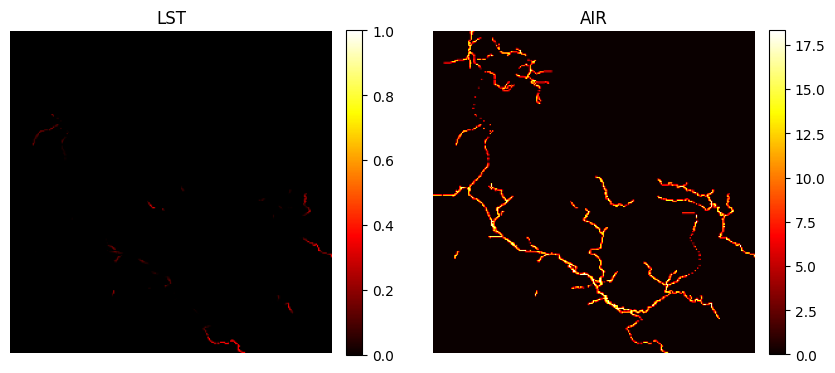

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



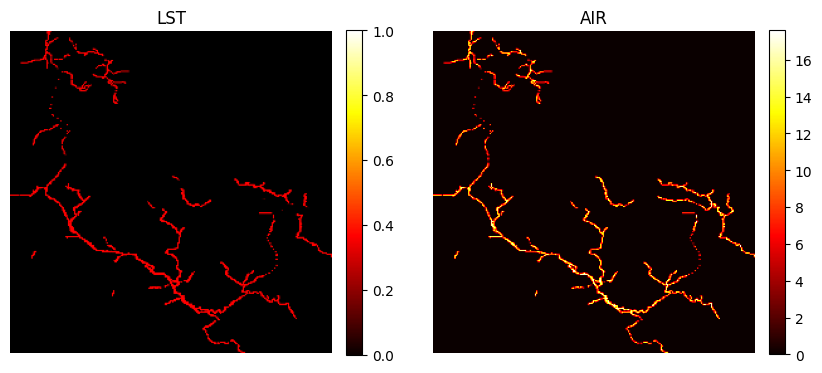

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



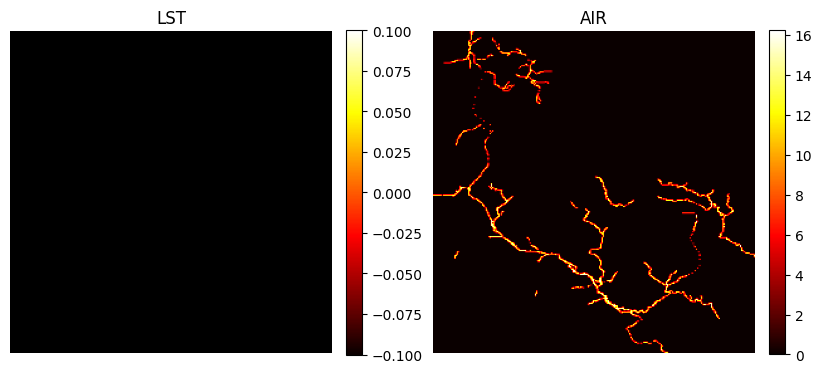

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



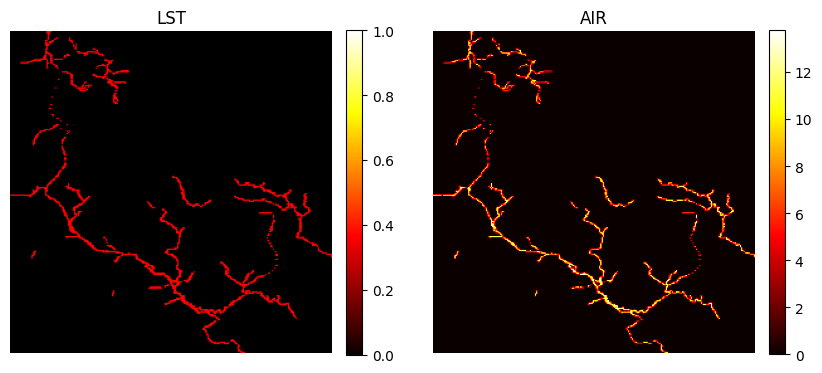

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



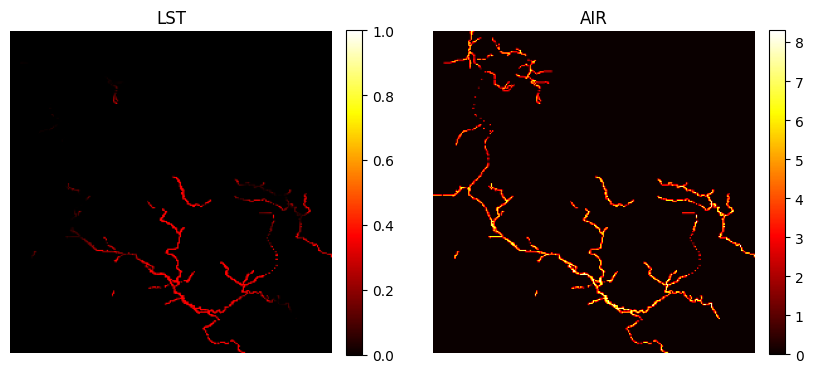

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



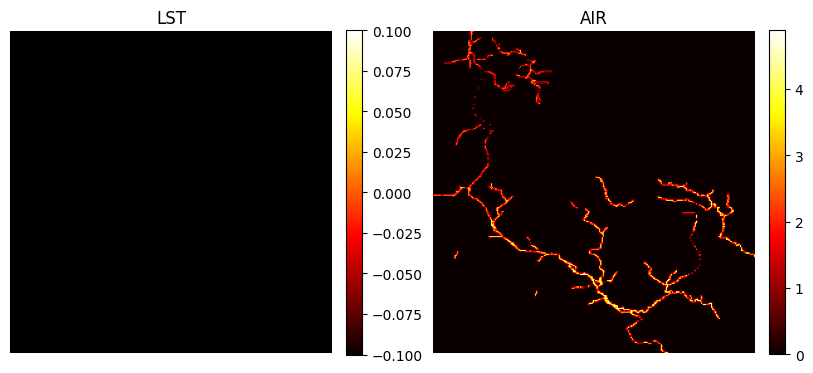

LST Shape: (256, 256, 3)
AIR Shape: (256, 256)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming masked_inputs and airtemp_data are lists of arrays
for img_data, airtemp_dat in zip(masked_inputs, airtemp_data):
    # Create a figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the figure size if needed

    # Plot the first image (LST)
    img1 = axes[0].imshow(np.clip(img_data * (6/255), 0, 1), cmap='hot')
    axes[0].set_title('LST')
    axes[0].axis('off')  # Remove the axis

    # Add colorbar next to the first subplot
    cbar1 = fig.colorbar(img1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

    # Plot the second image (AIR)
    img2 = axes[1].imshow(airtemp_dat, cmap='hot')
    axes[1].set_title('AIR')
    axes[1].axis('off')  # Remove the axis

    # Add colorbar next to the second subplot
    cbar2 = fig.colorbar(img2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

    # Show the images side by side
    plt.show()

    # Optionally, print the shape of the images
    print('LST Shape:', img_data.shape)
    print('AIR Shape:', airtemp_dat.shape)
    print()


In [ ]:
airtemp_data_flatten = airtemp_data.reshape(airtemp_data.shape[0], -1)

In [ ]:
filtered_lst = []
filtered_airtemp = []
del_indices = []
for i in range(masked_inputs.shape[0]):
  img_rgb = masked_inputs[i]
  img_gray = np.dot(img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  img_gray = img_gray[img_gray != 0] # flattening and filtering the image
  air_filt = airtemp_data_flatten[i][airtemp_data_flatten[i]!=0]
  if img_gray.shape == air_filt.shape and not np.all(img_gray==255): # only add the image if it contains temperature data for all the river
    filtered_lst.append(img_gray)
    filtered_airtemp.append(air_filt)
  else:
    del_indices.append(i)

    #print('pel mes',i)


filtered_lst = np.array(filtered_lst)
filtered_airtemp = np.array(filtered_airtemp)
period_filt = [item for i, item in enumerate(period) if i not in del_indices]


#### Plot histograms

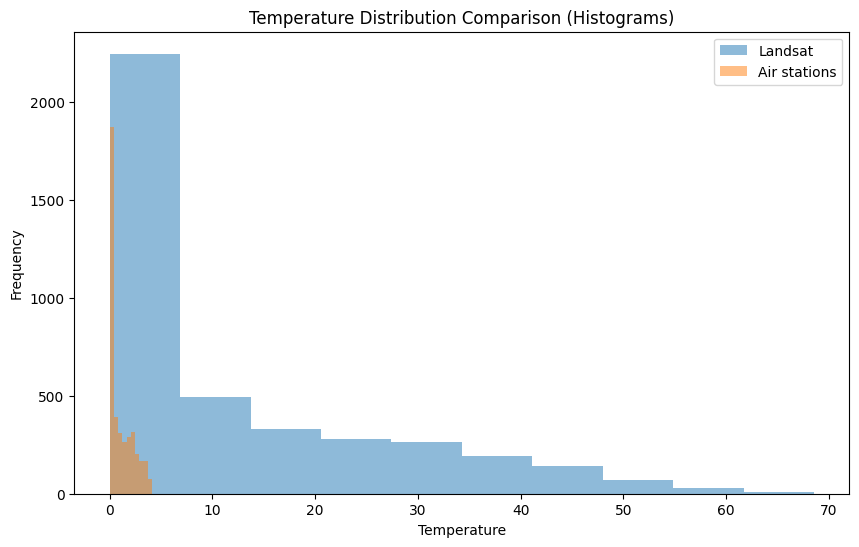

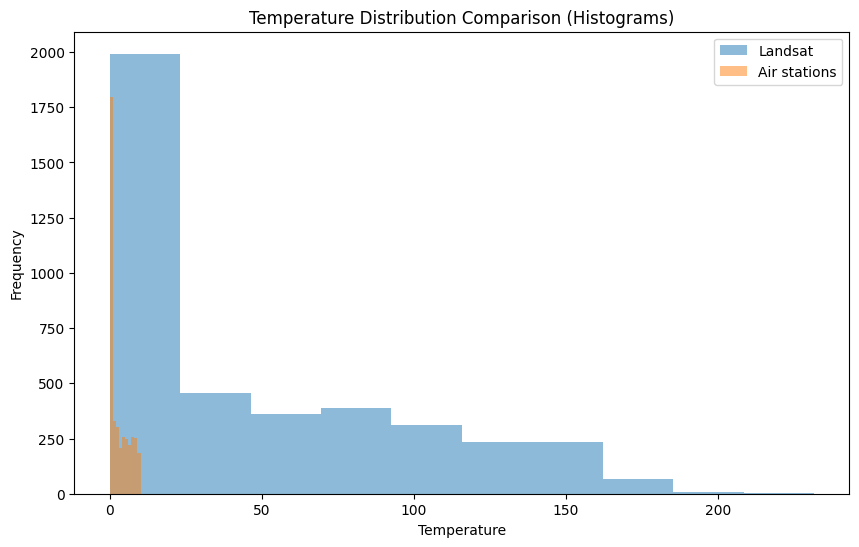

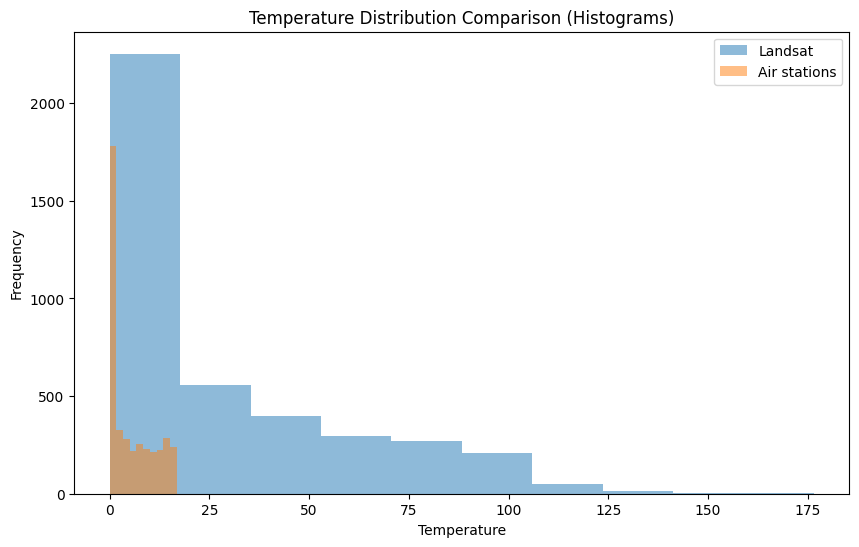

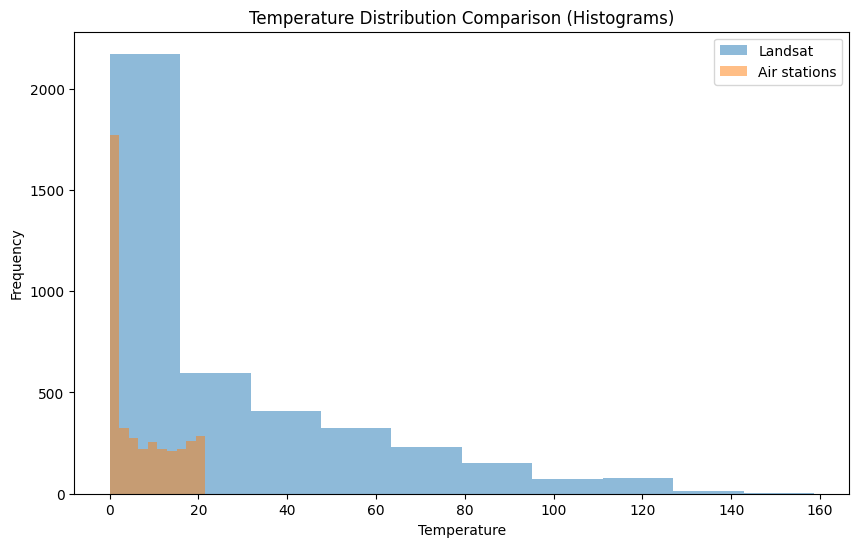

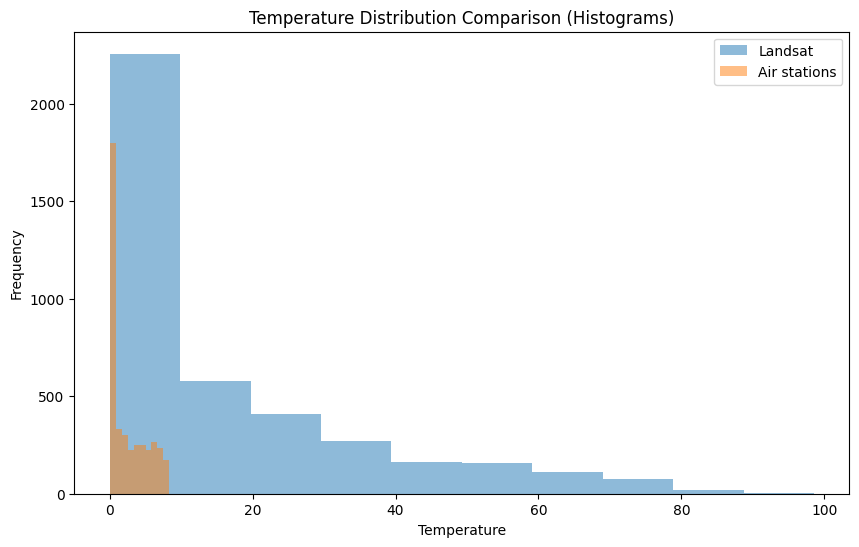

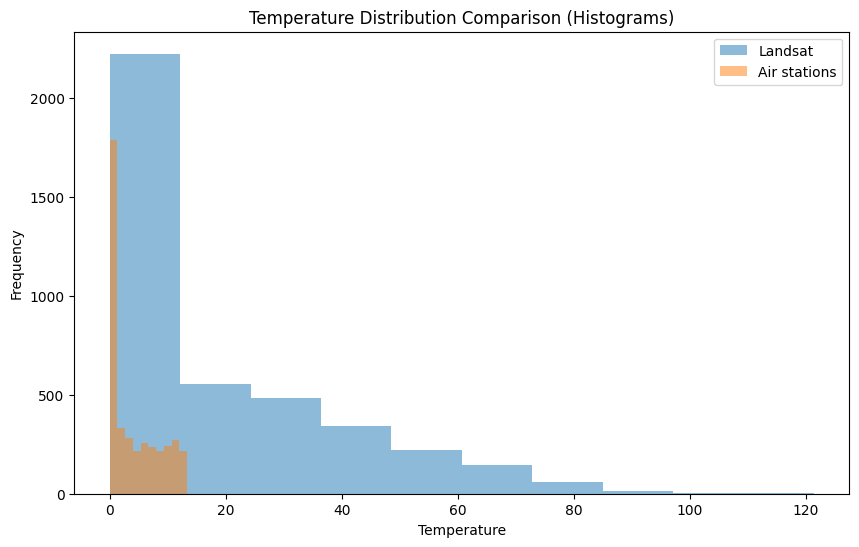

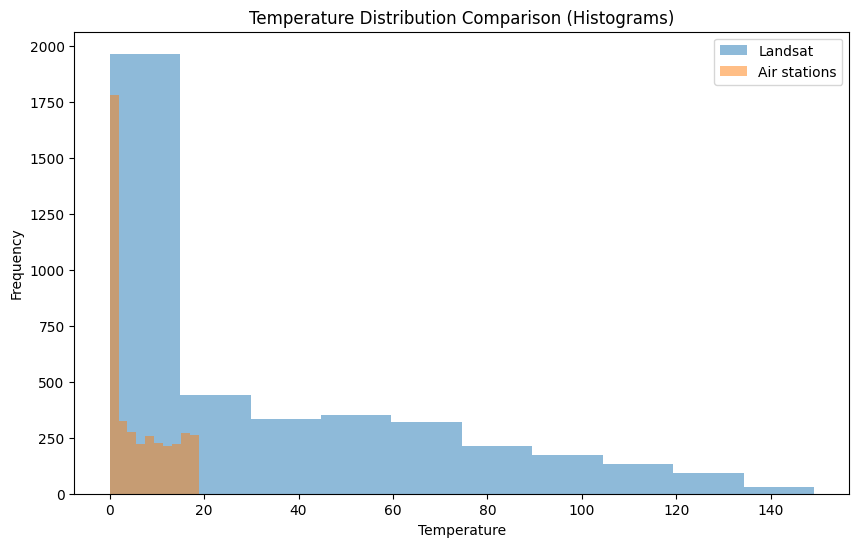

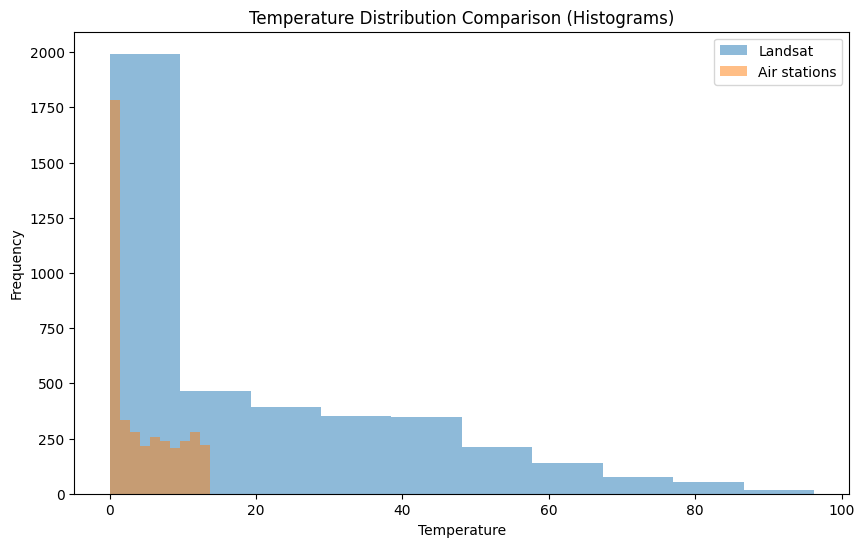

In [ ]:
for i in range(filtered_lst.shape[0]):
  # Example temperature arrays
  temperature_array1 = filtered_lst[i]
  temperature_array2 = filtered_airtemp[i]

  # Plot histograms for both temperature arrays
  plt.figure(figsize=(10, 6))
  plt.hist(temperature_array1, bins=10, alpha=0.5, label='Landsat')
  plt.hist(temperature_array2, bins=10, alpha=0.5, label='Air stations')

  # Customize the plot
  plt.title('Temperature Distribution Comparison (Histograms)')
  plt.xlabel('Temperature')
  plt.ylabel('Frequency')
  plt.legend(loc='upper right')
  plt.show()

#### Plot KDE

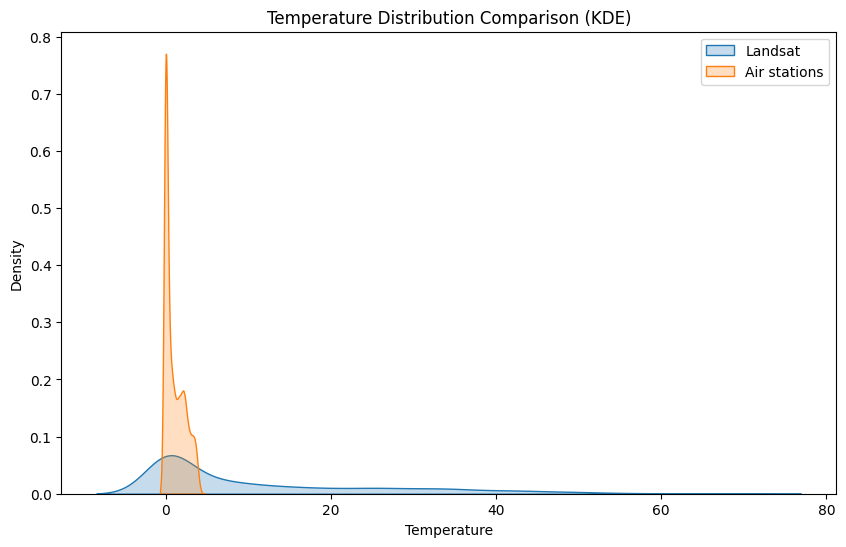

ValueError: x and y must have same first dimension, but have shapes (8,) and (4052,)

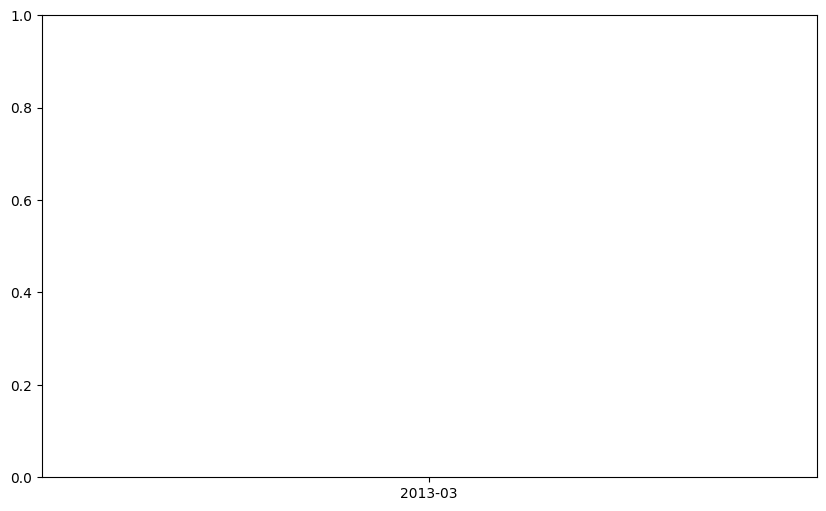

In [ ]:
import seaborn as sns
p_values = {}
for i in range(filtered_lst.shape[0]):
  # Example temperature arrays
  temperature_array1 = filtered_lst[i]
  temperature_array2 = filtered_airtemp[i]

  # Plot KDE for both temperature arrays
  plt.figure(figsize=(10, 6))
  sns.kdeplot(temperature_array1, label='Landsat', fill=True)
  sns.kdeplot(temperature_array2, label='Air stations', fill=True)

  # Customize the plot
  plt.title('Temperature Distribution Comparison (KDE)')
  plt.xlabel('Temperature')
  plt.ylabel('Density')
  plt.legend(loc='upper right')
  plt.show()

  stat, p_value = ks_2samp(temperature_array1, temperature_array2)
  mse = mean_squared_error(temperature_array1, temperature_array2)
  rmse = np.sqrt(mse)


  p_values[i] = [p_value,rmse]


In [ ]:
pd.DataFrame(p_values,index=['ks p_value', 'RMSE'])

0          1          2              3          4  \
ks p_value   0.000000   0.000000   0.000000  1.802509e-303   0.000000   
RMSE        17.216343  64.336185  34.546896   3.133075e+01  21.791898   

                    5          6          7  
ks p_value   0.000000   0.000000   0.000000  
RMSE        22.184641  41.252398  23.174486

#### Pixel wise difference

Mean Squared Error: 18.32615421119682


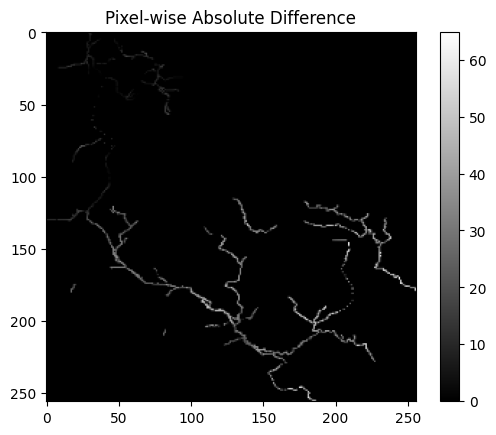

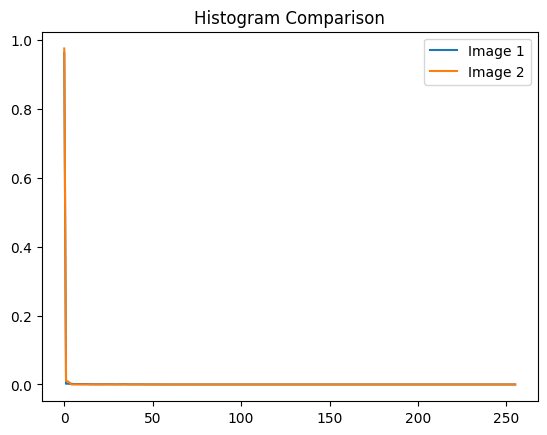

Histogram Correlation: 0.9999166652300582
Mean Squared Error: 255.91757648576151


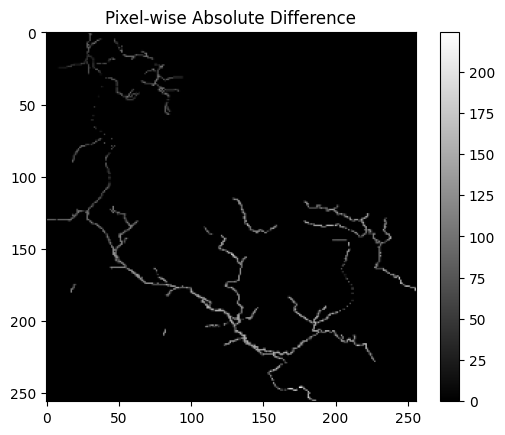

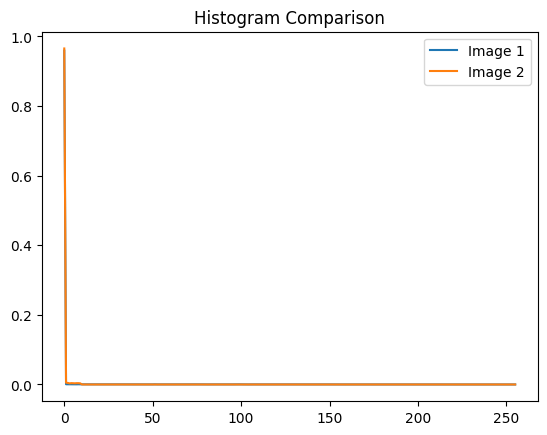

Histogram Correlation: 0.9999395162572553
Mean Squared Error: 1.7132293604081434


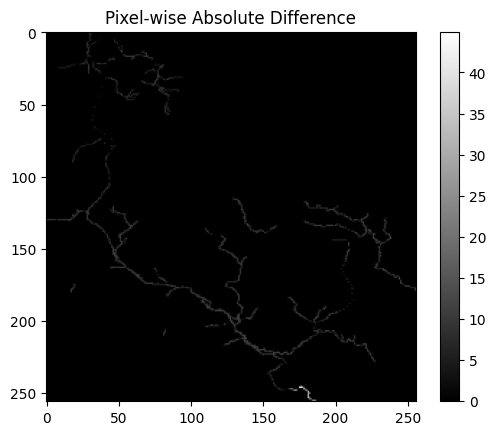

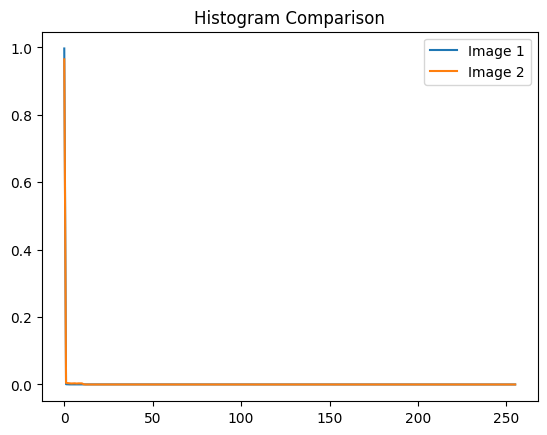

Histogram Correlation: 0.999944658313634
Mean Squared Error: 73.79170883395633


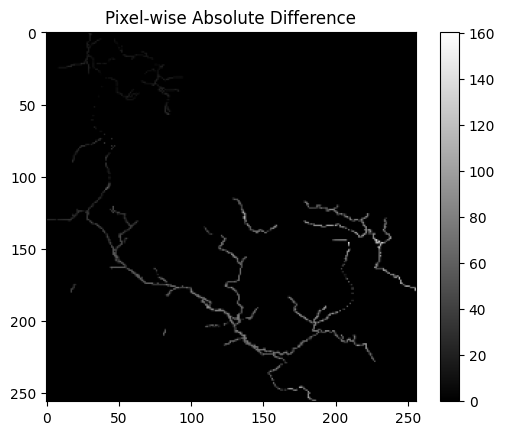

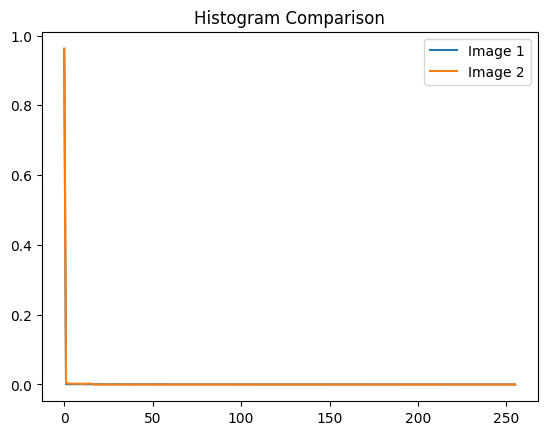

Histogram Correlation: 0.9999723661151361
Mean Squared Error: 60.691937852276304


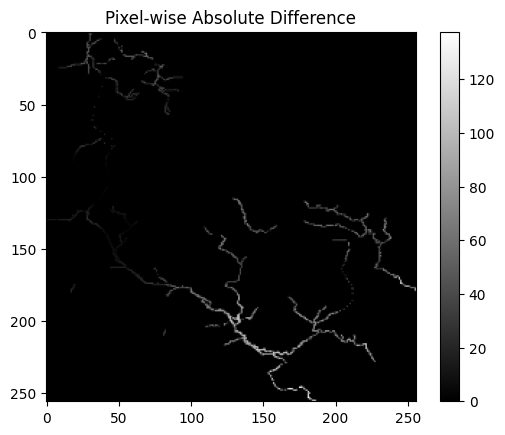

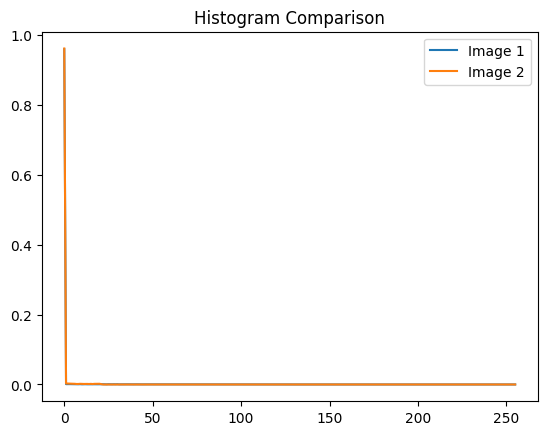

Histogram Correlation: 0.9999800306405383
Mean Squared Error: 4.8949893493358045


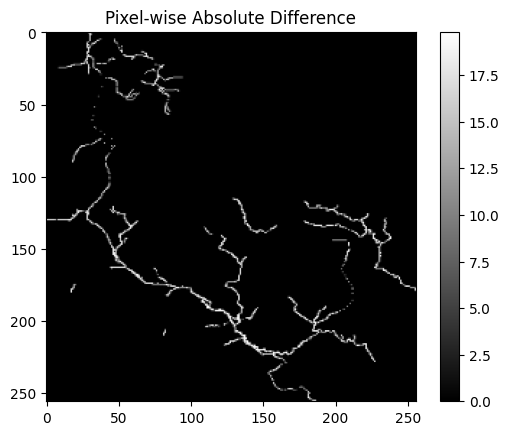

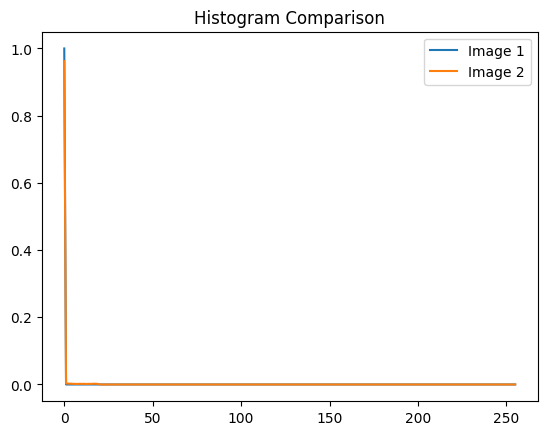

Histogram Correlation: 0.999960679547001
Mean Squared Error: 3.1876759106357886


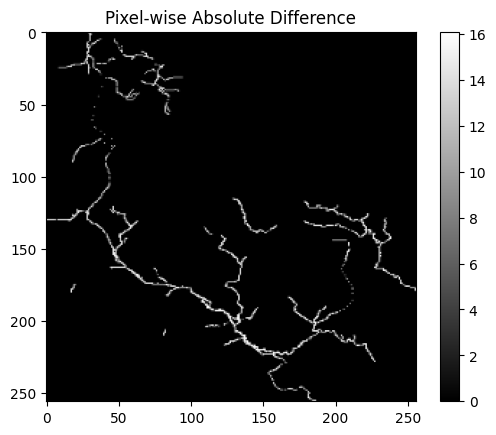

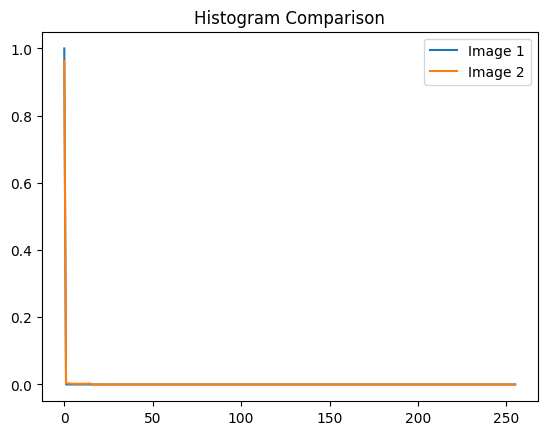

Histogram Correlation: 0.9999513624822133
Mean Squared Error: 5.546632557800866


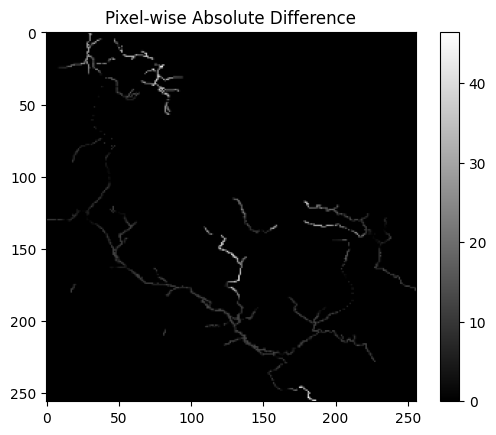

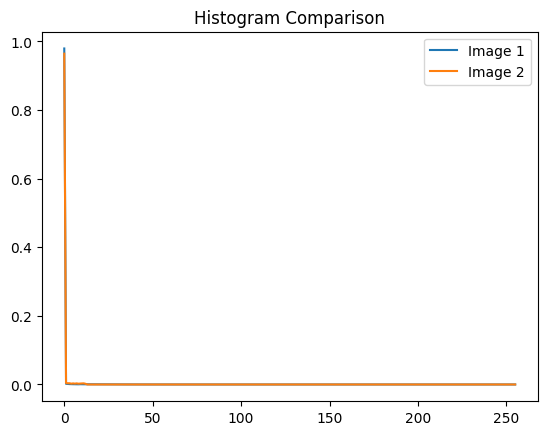

Histogram Correlation: 0.9999699244779882
Mean Squared Error: 18.73606787920868


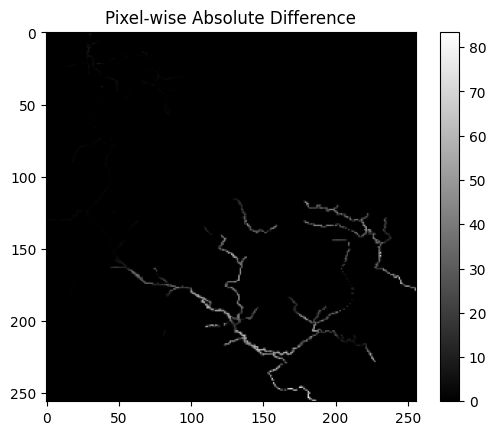

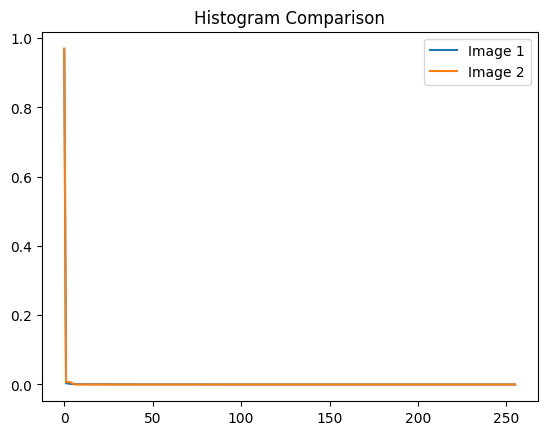

Histogram Correlation: 0.9999545052872306
Mean Squared Error: 1.0545840733126337


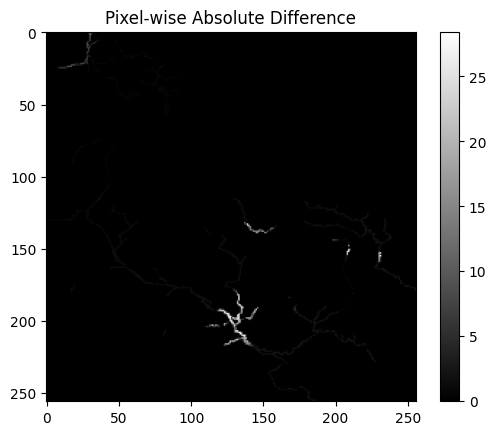

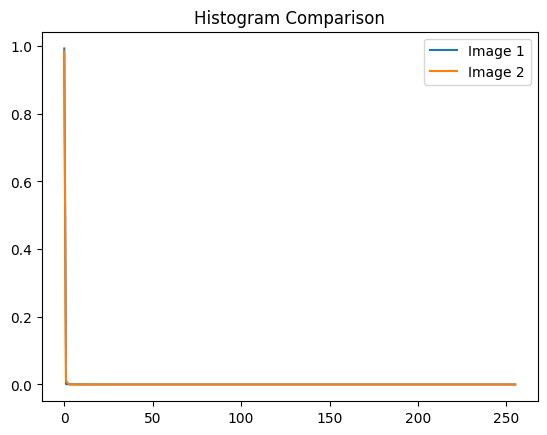

Histogram Correlation: 0.9999399651127167
Mean Squared Error: 0.1808704121595826


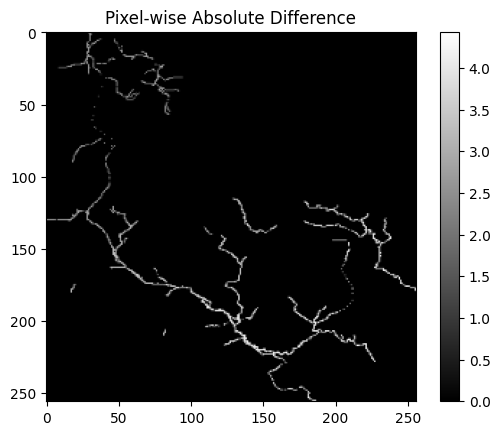

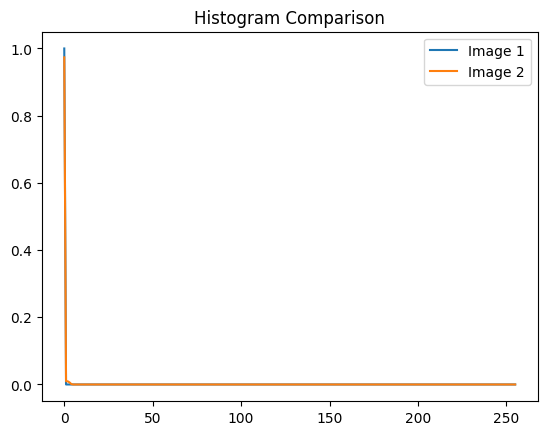

Histogram Correlation: 0.9998849349398076
Mean Squared Error: 0.22441148738238856


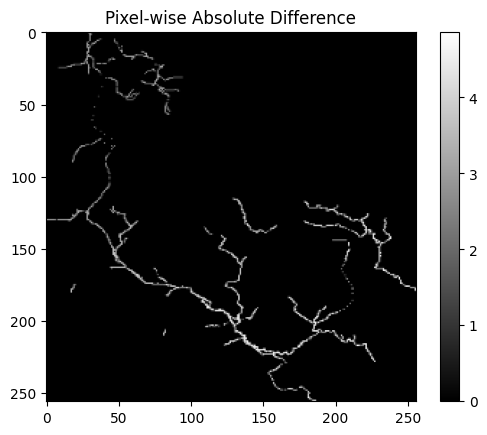

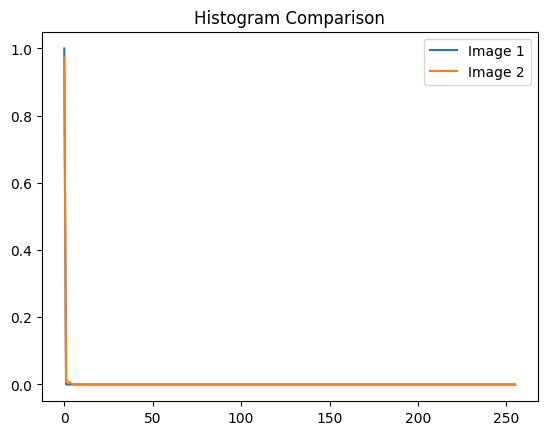

Histogram Correlation: 0.9998903193509198
Mean Squared Error: 29.36159472070591


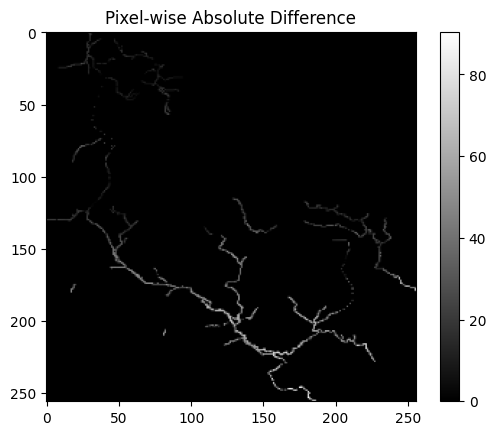

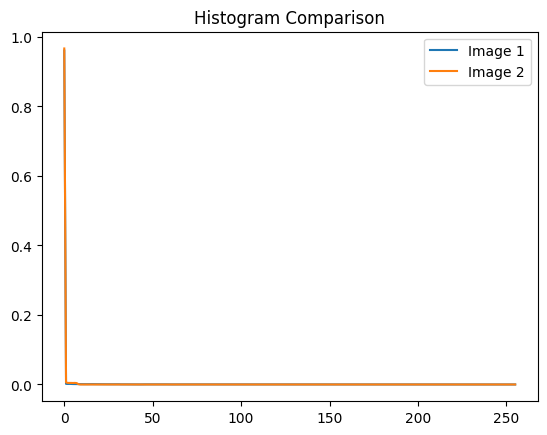

Histogram Correlation: 0.9999518579694447
Mean Squared Error: 1.6536841567052574


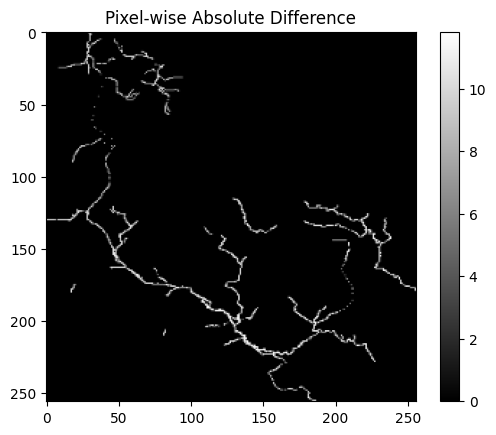

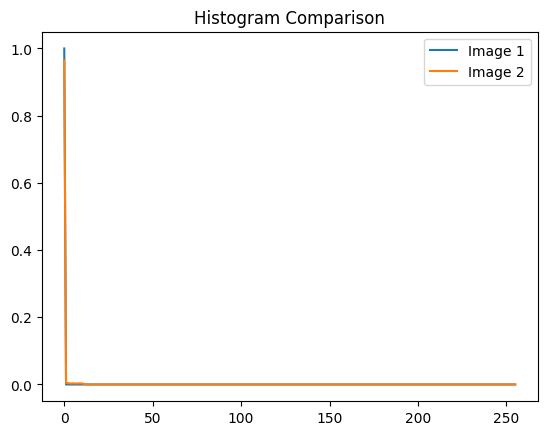

Histogram Correlation: 0.9999382946887557
Mean Squared Error: 30.42946402268817


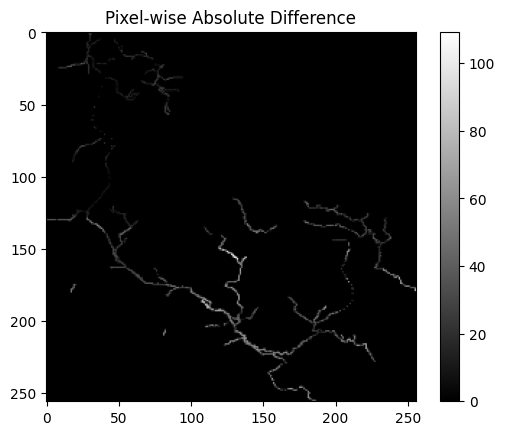

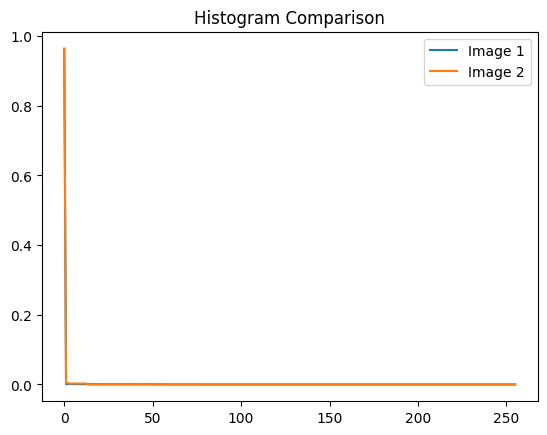

Histogram Correlation: 0.9999677714399154
Mean Squared Error: 105.2174829690107


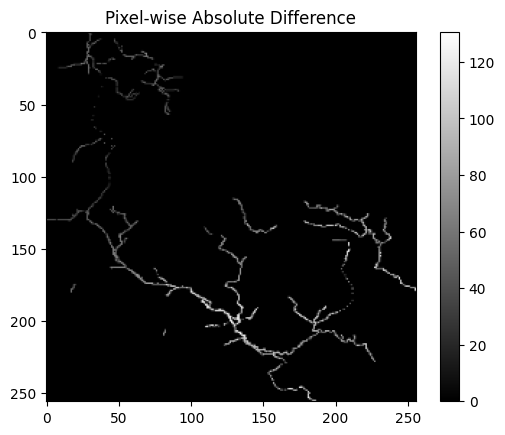

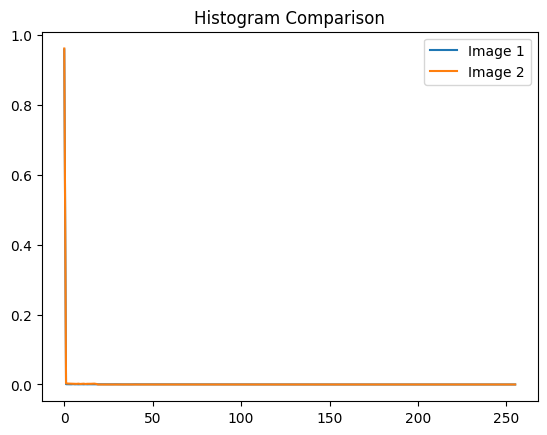

Histogram Correlation: 0.9999712402584165
Mean Squared Error: 3.843283128178557


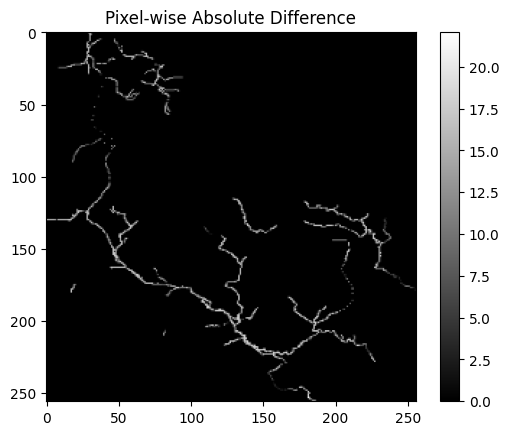

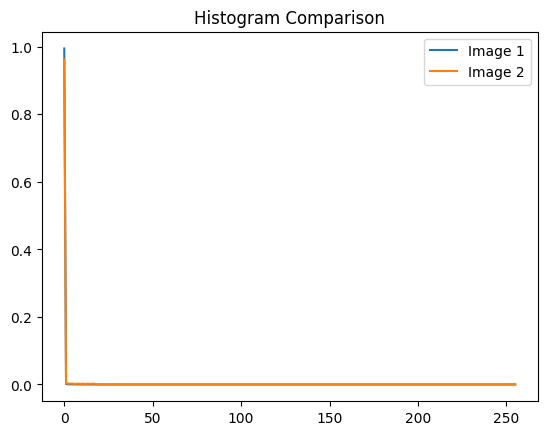

Histogram Correlation: 0.99996769360132
Mean Squared Error: 9.84553860171115


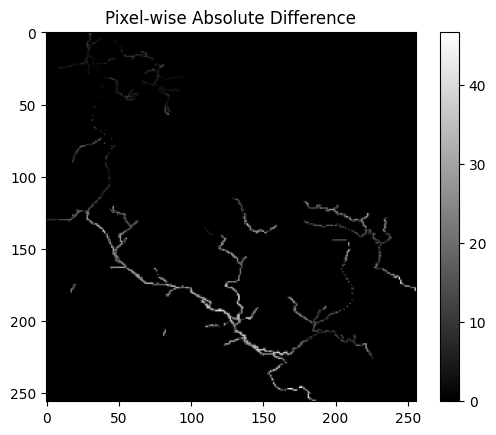

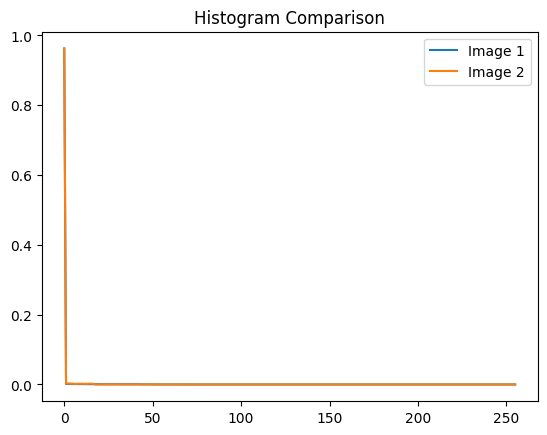

Histogram Correlation: 0.9999818282466315
Mean Squared Error: 3.240202076407909


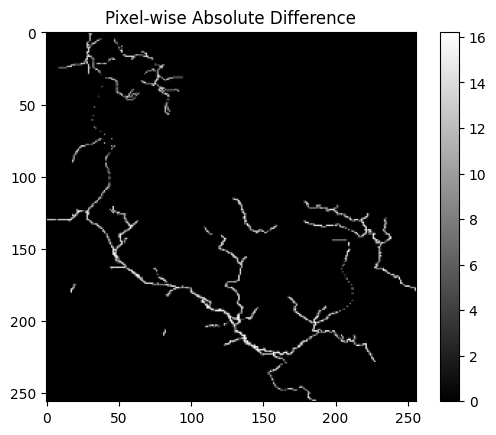

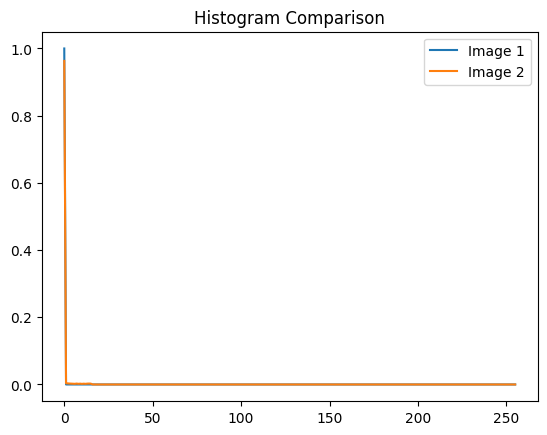

Histogram Correlation: 0.999952030909415
Mean Squared Error: 33.205478480799485


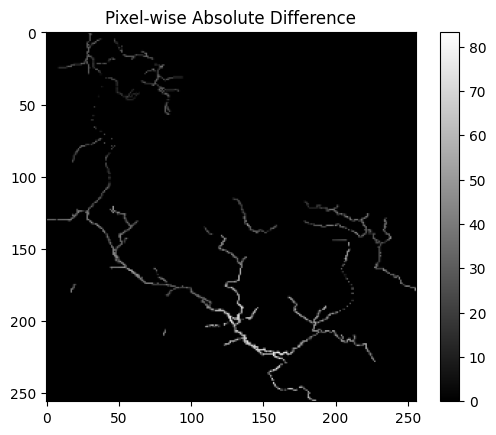

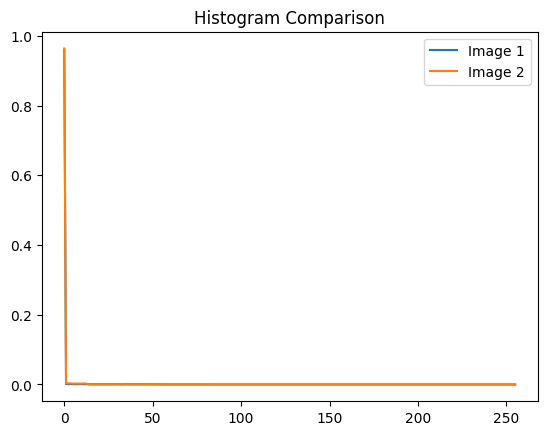

Histogram Correlation: 0.9999670964464554
Mean Squared Error: 2.447006723296815


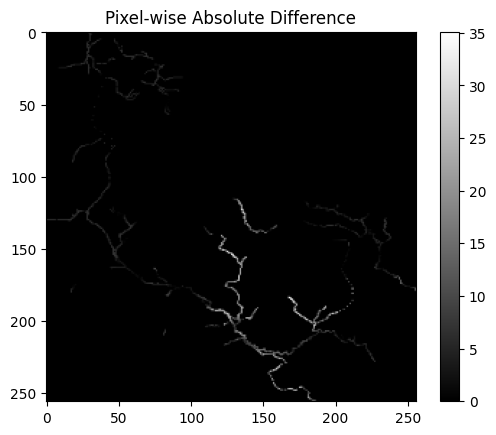

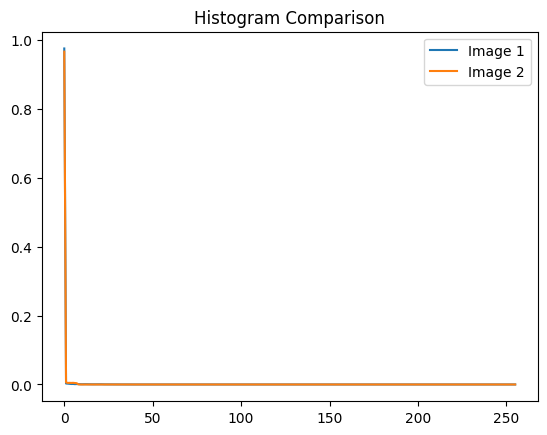

Histogram Correlation: 0.9999638176609452
Mean Squared Error: 0.22796102166244603


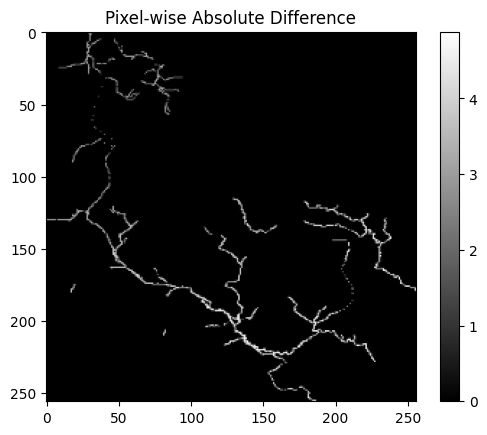

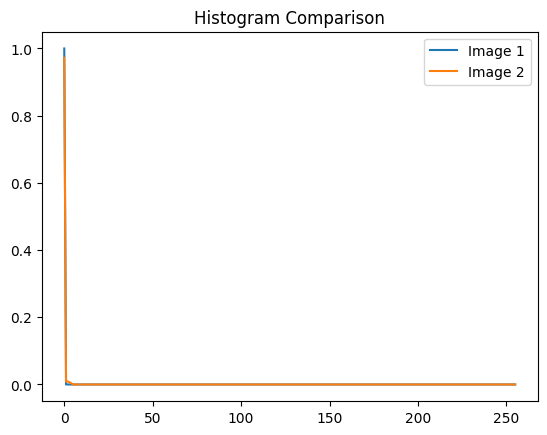

Histogram Correlation: 0.9998908448043434


In [ ]:
import cv2  # OpenCV for histogram calculation
import matplotlib.pyplot as plt

def mse(imageA, imageB):
    # Compute the Mean Squared Error between the two images
    return np.mean((imageA - imageB) ** 2)

for img_data, airtemp_dat in zip(masked_inputs, airtemp_data):
  img_gray = np.dot(img_data[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  absolute_difference = np.abs(img_gray - airtemp_dat)

  img1 = img_gray
  img2 = airtemp_dat

  # Display the result
  mse_value = mse(img1, img2)
  print("Mean Squared Error:", mse_value)

  plt.imshow(absolute_difference, cmap='gray')
  plt.title("Pixel-wise Absolute Difference")
  plt.colorbar()
  plt.show()


In [ ]:
mediana_lst = np.median(filtered_lst, axis=1)

mediana_air = np.median(filtered_airtemp, axis=1)
print(mediana_lst.shape,mediana_air.shape)

(8,) (8,)


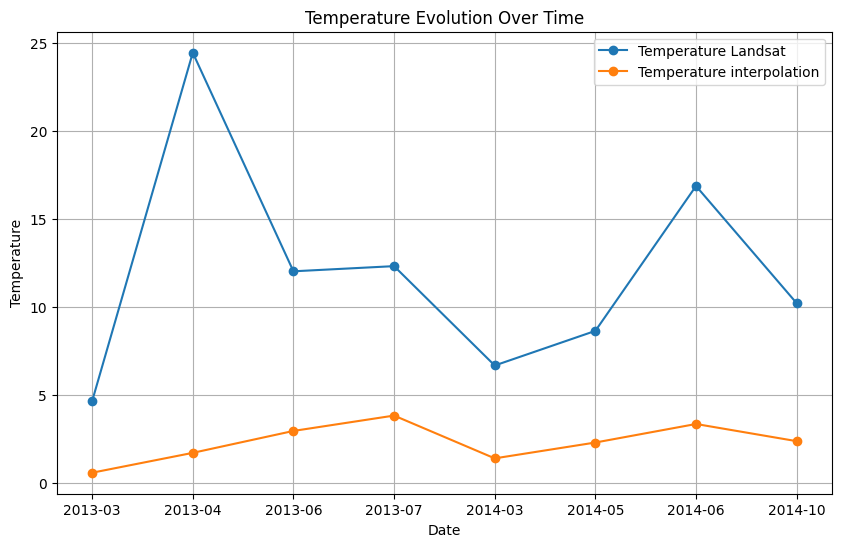

In [ ]:
plt.figure(figsize=(10,6))
# Plot df1
plt.plot(period_filt, mediana_lst, label='Temperature Landsat', marker='o')

# Plot df2
plt.plot(period_filt, mediana_air, label='Temperature interpolation', marker='o')

# Customize the plot
plt.title('Temperature Evolution Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## Obtain NVDI data

In [30]:
W = 256# with 64 works LR
dir_paths = ['/content/gdrive/MyDrive/TFG/data/raw/ndvi']
list_rgb = [False]

In [31]:
data, time_slots = load_data(dir_paths,W,list_rgb)

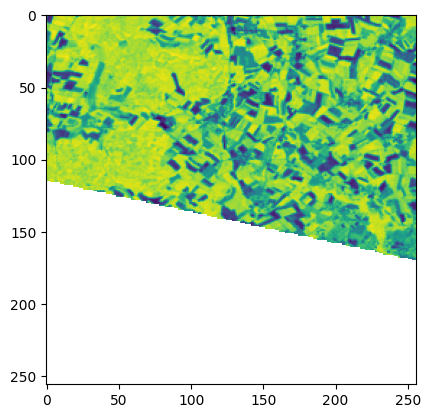

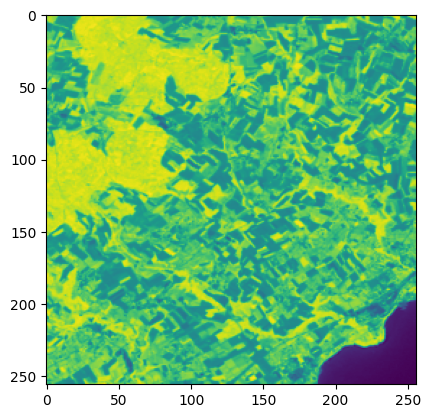

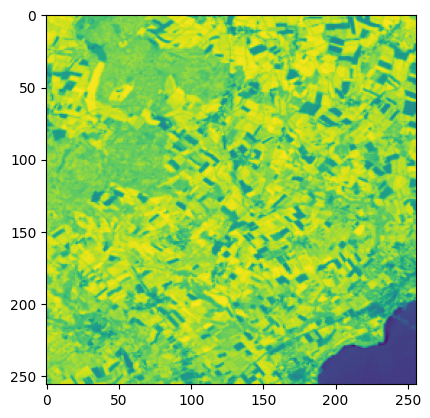

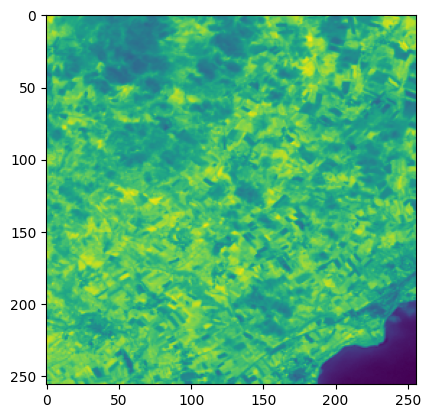

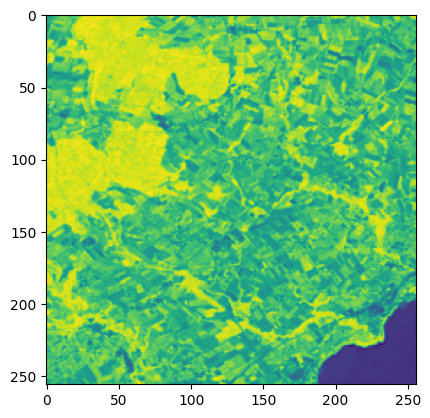

In [36]:
for i in data[dir_paths[0]]:
  plt.imshow(i)
  plt.show()

In [ ]:
p